In [1]:
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from Bio import SeqIO
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
import re
from ete3 import Tree
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
pallete = px.colors.qualitative.Vivid
import plotly.io as pio
pio.templates.default = "plotly_white"
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)


fontsize = 24
plt.rcParams.update({'font.size': fontsize, 'font.weight': 'normal', 'axes.grid': False, 'savefig.transparent': False})
sns.set_style("white")
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
resolve_tree = False
resolve_ccdb = False # use taxonome name resolution
tree_name = "ALLMB"
with_model_weighting = True

group_by_options = ["genus", "family", "time_5", "time_10", "time_20"]
add_missing_options = {False: "include_missing", True: "include_all_possible_missing"}
chromevol_workdir = f"../chromevol/{'with model_weighting' if with_model_weighting else ''}"
ccdb_path = "../ccdb/all_data_171122.csv"

taxonomic_classification_path = "../trees/resolved_ALLMB_name_resolution_on_none_with_added_ccdb_and_wo_counts_names_classification_data.csv"
old_ploidb_dir = "/groups/itay_mayrose/michaldrori/MSA_JmodelTree/Ploidb_dir/"
old_ploidb_path = "../chromevol/results/processed_old_ploidb.pkl"
kew_db_path = "../chromevol/results/cvalues_db.csv"
processed_kew_db_path = "../chromevol/results/processed_kew_db.pkl"

ott_genus_db_path = "../chromevol/results/one_two_tree/genus/db.csv"

In [3]:
classification_db_path = "../wfo_classification.txt"
classification_data = pd.read_csv(classification_db_path, sep="\t", nrows=5)
taxonomic_classification = pd.read_csv(taxonomic_classification_path)
name_to_genus, name_to_family = taxonomic_classification.set_index("taxon")["genus"].to_dict(), taxonomic_classification.set_index("taxon")["family"].to_dict()

# Parse old ploidb (Glick 2014)

In [4]:
def process_old_ploidb(dir: str) -> dict[str, pd.DataFrame]:
    genus_to_ploidy_classification = dict()
    for genus in os.listdir(dir):
        classification_path = f"{dir}{genus}/{genus}_Chromevol/chromevol_out/{genus}_CriteriaPloidy.csv"
        if os.path.exists(classification_path):
            ploidy_classification = pd.read_csv(classification_path, usecols=["Taxon", "Chromosome count", "Ploidy inference"]).dropna(how="all")
            if ploidy_classification.shape[0] > 0:
                ploidy_classification["Taxon"] = ploidy_classification["Taxon"].apply(lambda name: name.replace("_", " ").lower() if pd.notna(name) else name)
                genus_to_ploidy_classification[genus.lower()] = ploidy_classification
    return genus_to_ploidy_classification

if not os.path.exists(old_ploidb_path):
    genus_to_old_ploidy_classification = process_old_ploidb(dir=old_ploidb_dir)
    with open(old_ploidb_path, "wb") as out:
        pickle.dump(genus_to_old_ploidy_classification, out)
else:
    with open(old_ploidb_path, "rb") as inf:
        genus_to_old_ploidy_classification = pickle.load(inf)

ploidb_dfs = []
for genus in genus_to_old_ploidy_classification:
    df = genus_to_old_ploidy_classification[genus]
    df["genus"] = genus
    ploidb_dfs.append(df)
ploidb = pd.concat(ploidb_dfs)
print(f"# records with ploidy level in ploidb = {len(ploidb.loc[ploidb['Ploidy inference'].notna(), 'Taxon'].unique()):,}")

# records with ploidy level in ploidb = 61,972


# Parse the currect PloiDB in all the pipeline execlution modes

In [5]:
def plot_thresholds_distributions(curr_db: pd.DataFrame):
    fig = make_subplots(rows=1, cols=2, subplot_titles=["(a)", "(b)", "(c)", "(d)"], 
                        y_title='Frequency', shared_xaxes="columns", horizontal_spacing=0.1, vertical_spacing=0.1,)


    fig.add_trace(go.Histogram(x=curr_db["diploidy_threshold"],
                               histnorm='probability', 
                               marker_color=pallete[1],
                               opacity=0.8,
                               nbinsx=20,
                               name="Diploidy"),
                 row=1, col=1)

    fig.add_trace(go.Histogram(x=curr_db["polyploidy_threshold"], 
                               histnorm='probability', 
                               marker_color=pallete[0],
                               opacity=0.8,
                               nbinsx=20,
                               name="Polyploidy"),
                 row=1, col=1)


    fig.add_trace(go.Histogram(x=curr_db["diploidy_coeff"], 
                               histnorm='probability', 
                               marker_color=pallete[1],
                               opacity=0.8,
                               nbinsx=20,
                              showlegend=False),
                 row=1, col=2)

    fig.add_trace(go.Histogram(x=curr_db["polyploidy_coeff"], 
                               histnorm='probability', 
                               marker_color=pallete[0],
                               opacity=0.8,
                               nbinsx=20,
                              showlegend=False),
                 row=1, col=2)


    fig.update_yaxes(title_text="", nticks=10, range=[0,1],
                    showline=True, linewidth=1, linecolor="black", mirror="all") # only once, yticks more dense, all scale 0-1
    fig.update_xaxes(title_text="", showline=True, linewidth=1, linecolor="black", mirror=True)


    fig.update_layout({'xaxis':{'range': [0, 1], 'showline': True, "linewidth": 1, "linecolor": "black", "title_text": "Threshold"},
                       'xaxis2':{'range': [0, 1], 'showline': True, "linewidth": 1, "linecolor": "black", "title_text": "Matthew's coefficient"}},
                      barmode='overlay', 
                      width=1000,
                      height=400,
                      font_color="black",
                      title_font_family="Ariel",
                      yaxis_range=[0,1],
                      xaxis_range=[0,1],
                      legend=dict(yanchor="bottom",y=-0.15,x=0.4),
                      legend_orientation="h",
                     margin=dict(l=30, r=30, t=30, b=30),
                     )
    fig.update_traces(marker_size=12,
                    marker_line=dict(width=2, color="black"),
                    selector=dict(mode='markers')
                    )
    fig.show()

In [6]:
# parse current ploidb based on all runnig modes
comb_to_db = dict()
for am in add_missing_options:
    print(f"\n\n###########################################\n############# with{'' if am else 'out'} missing ################\n###########################################")
    comb_to_db[am] = dict()
    for gb in group_by_options:
        print(f"\n########## group by = {gb} ###############") 
        suffix = "" if (gb.startswith("time") and not am) else f"_{add_missing_options[am]}"
        chromevol_output_dir = f"{chromevol_workdir}by_{gb}_on_{'' if resolve_tree else 'un'}resolved_{tree_name}_and_{'' if resolve_ccdb else 'un'}resolved_ccdb{suffix}/"
        stats_path = f"{chromevol_output_dir}/stats.csv"
        curr_db_path = f"../chromevol/results/with{'out' if not with_model_weighting else ''}_model_weighting/ploidb_by_{gb}_with{'' if am else 'out'}_missing.csv"
        if not os.path.exists(curr_db_path):
            continue
        curr_db = pd.read_csv(curr_db_path)
        try:
            comb_to_db[am][gb] = curr_db
            print(f"\n\n# records = {curr_db.shape[0]:,}")
            print(f"# families = {len(curr_db.Family.dropna().unique()):,}")
            print(f"# angosperm families = {len(curr_db.loc[curr_db.major_group == 'angiosperms', 'Family'].dropna().unique()):,}")
            print(f"# gymnosperms families = {len(curr_db.loc[curr_db.major_group == 'gymnosperms', 'Family'].dropna().unique()):,}")
            print(f"\n# records with ploidy classification = {curr_db.loc[curr_db['Ploidy inference'].notna()].shape[0]:,}")
            print(f"# angiosperms = {curr_db.loc[(curr_db.major_group == 'angiosperms')].shape[0]:,}")
            print(f"# gymnosperms = {curr_db.loc[(curr_db.major_group == 'gymnosperms')].shape[0]:,}")
            print(f"\n% diploids = {np.round(curr_db.loc[curr_db['Ploidy inference'] == 0].shape[0]/curr_db.dropna(subset=['Ploidy inference']).shape[0]*100, 2)}% ({curr_db.loc[curr_db['Ploidy inference'] == 0].shape[0]:,}/{curr_db.dropna(subset=['Ploidy inference']).shape[0]:,})")
            print(f"% polyploids = {np.round(curr_db.loc[curr_db['Ploidy inference'] == 1].shape[0]/curr_db.dropna(subset=['Ploidy inference']).shape[0]*100, 2)}% ({curr_db.loc[curr_db['Ploidy inference'] == 1].shape[0]:,}/{curr_db.dropna(subset=['Ploidy inference']).shape[0]:,})")
            print(f"% missing = {np.round(curr_db.loc[curr_db['Ploidy inference'].isna()].shape[0]/curr_db.shape[0]*100, 2)}% ({curr_db.loc[curr_db['Ploidy inference'].isna()].shape[0]:,}/{curr_db.shape[0]:,})")
            print(f"% polyploids across angiosperms = {np.round(curr_db.loc[(curr_db['Ploidy inference'] == 1) & (curr_db.major_group == 'angiosperms')].shape[0]/curr_db.loc[(curr_db['Ploidy inference'].notna()) & (curr_db.major_group == 'angiosperms')].shape[0]*100,2)}% ({curr_db.loc[(curr_db['Ploidy inference'] == 1) & (curr_db.major_group == 'angiosperms')].shape[0]} / {curr_db.loc[(curr_db['Ploidy inference'].notna()) & (curr_db.major_group == 'angiosperms')].shape[0]})")
            print(f"% polyploids across gymnosperms = {np.round(curr_db.loc[(curr_db['Ploidy inference'] == 1) & (curr_db.major_group == 'gymnosperms')].shape[0]/curr_db.loc[(curr_db['Ploidy inference'].notna()) & (curr_db.major_group == 'gymnosperms')].shape[0]*100,2)}% ({curr_db.loc[(curr_db['Ploidy inference'] == 1) & (curr_db.major_group == 'gymnosperms')].shape[0]} / {curr_db.loc[(curr_db['Ploidy inference'].notna()) & (curr_db.major_group == 'gymnosperms')].shape[0]})")
        except:
            pass



###########################################
############# without missing ################
###########################################

########## group by = genus ###############


# records = 57,424
# families = 220
# angosperm families = 208
# gymnosperms families = 8

# records with ploidy classification = 56,595
# angiosperms = 56,878
# gymnosperms = 459

% diploids = 68.44% (38,736/56,595)
% polyploids = 31.56% (17,859/56,595)
% missing = 1.44% (829/57,424)
% polyploids across angiosperms = 31.77% (17814 / 56066)
% polyploids across gymnosperms = 5.66% (25 / 442)

########## group by = family ###############


# records = 66,296
# families = 246
# angosperm families = 238
# gymnosperms families = 8

# records with ploidy classification = 63,168
# angiosperms = 65,759
# gymnosperms = 537

% diploids = 40.62% (25,656/63,168)
% polyploids = 59.38% (37,512/63,168)
% missing = 4.72% (3,128/66,296)
% polyploids across angiosperms = 59.82% (37467 / 62631)
% polyploids across gymnosper

/var/tmp/pbs.6259885.power8.tau.ac.il/ipykernel_54914/635990073.py:14: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  curr_db = pd.read_csv(curr_db_path)




# records = 174,763
# families = 206
# angosperm families = 180
# gymnosperms families = 5

# records with ploidy classification = 99,728
# angiosperms = 173,861
# gymnosperms = 352

% diploids = 76.59% (76,381/99,728)
% polyploids = 23.41% (23,347/99,728)
% missing = 42.94% (75,035/174,763)
% polyploids across angiosperms = 23.5% (23292 / 99134)
% polyploids across gymnosperms = 9.63% (26 / 270)

########## group by = family ###############

########## group by = time_5 ###############

########## group by = time_10 ###############

########## group by = time_20 ###############


In [7]:
n_falling_between = comb_to_db[False]["genus"].loc[(comb_to_db[False]["genus"]["Ploidy inference"].isna()) & 
                               ((comb_to_db[False]["genus"]["Ploidy transitions frequency"] > 0.25) |
                                (comb_to_db[False]["genus"]["Ploidy transitions frequency"] < 0.75))].shape[0]
n_bad_mappings = comb_to_db[False]["genus"].loc[(comb_to_db[False]["genus"]["Ploidy inference"].isna()) & 
                               (comb_to_db[False]["genus"].frequency_of_successful_mappings < 0.8)].shape[0]
print(f"in inference at genus level without missing counts, {n_falling_between} taxa has ploidy tranistion frequenceis based on ploidy level could not be determined and {n_bad_mappings} taxa has low frequecy of successful mappings") 

in inference at genus level without missing counts, 829 taxa has ploidy tranistion frequenceis based on ploidy level could not be determined and 74 taxa has low frequecy of successful mappings


In [8]:
genus_to_percent_poly = comb_to_db[False]["genus"].groupby("genus")[["Ploidy inference", "major_group"]].agg({"major_group": lambda n: n.values[0],
                                                                                                              "Ploidy inference": lambda n: n.dropna().sum() / len(n.dropna()) * 100}).reset_index().rename(columns={"Ploidy inference": "%polyploids"})
genus_to_percent_poly.sort_values("%polyploids", ascending=False, inplace=True)
print(f"# polyploid rich (>50%) angiosperm genera = {genus_to_percent_poly.loc[(genus_to_percent_poly['%polyploids'] > 50) & (genus_to_percent_poly.major_group == 'angiosperms')].shape[0]}")
print(f"# polyploid rich (>50%) gimnosperm genera = {genus_to_percent_poly.loc[(genus_to_percent_poly['%polyploids'] > 50) & (genus_to_percent_poly.major_group != 'angiosperms')].shape[0]}")

# polyploid rich (>50%) angiosperm genera = 357
# polyploid rich (>50%) gimnosperm genera = 0


In [9]:
family_to_percent_poly = comb_to_db[False]["genus"].groupby("Family")[["Ploidy inference", "major_group"]].agg({"major_group": lambda n: n.values[0],
                                                                                                              "Ploidy inference": lambda n: n.dropna().sum() / len(n.dropna()) * 100}).reset_index().rename(columns={"Ploidy inference": "%polyploids"})
family_to_percent_poly.sort_values("%polyploids", ascending=False, inplace=True)
print(f"# polyploid poor (<=20%) families = {family_to_percent_poly.loc[(family_to_percent_poly['%polyploids'] <= 20)].shape[0]} out of {family_to_percent_poly.shape[0]:,} families")
print(f"# polyploid rich (>80%) families = {family_to_percent_poly.loc[(family_to_percent_poly['%polyploids'] >= 80)].shape[0]} out of {family_to_percent_poly.shape[0]:,} families")

# polyploid poor (<=20%) families = 110 out of 220 families
# polyploid rich (>80%) families = 8 out of 220 families


# Parse the KEW (Cvalues) DB

In [10]:
# parse cvalues db
kew_db = pd.read_csv(kew_db_path)
kew_db["taxon"] = kew_db.apply(lambda rec: f"{rec.Genus} {rec.Species}" + (f" {rec.Subspecies}" if pd.notna(rec.Subspecies) else ''), axis=1)
kew_db["kew_db_chromosome_number"] = kew_db["Chromosome Number (2n)"].apply(lambda s: np.nan if s == "-" else int(s)/2)
kew_db["Ploidy Level (x)"] = kew_db["Ploidy Level (x)"].replace({"-": np.nan}).astype(np.float64)
kew_db["Ploidy Level (x)"] = kew_db["Ploidy Level (x)"].apply(lambda x: np.nan if pd.isna(x) else (1 if x > 2 else 0))
kew_db = kew_db.loc[kew_db["Ploidy Level (x)"].notna()]
print(f"# records with ploidy level in kew_db = {len(kew_db['taxon'].unique()):,}")

# records with ploidy level in kew_db = 7,495


In [11]:
kew_db.taxon = kew_db.taxon.str.lower()
intersection = kew_db.merge(comb_to_db[False]["genus"], left_on="taxon", right_on="Taxon", how="inner")

debug = intersection[intersection.taxon.isin(intersection.taxon[intersection.taxon.duplicated()])].sort_values("taxon")[["taxon", "kew_db_chromosome_number", "Chromosome count",
                                                                                                                 "Ploidy Level (x)", "Ploidy inference"]]
interesting_taxa = debug.loc[(debug["kew_db_chromosome_number"] != debug["Chromosome count"]) &
          (debug["Ploidy Level (x)"] == debug["Ploidy inference"])].taxon.unique()

interesting_taxa_2 = debug.loc[
          ((debug["kew_db_chromosome_number"] == debug["Chromosome count"]) &
          (debug["Ploidy Level (x)"] != debug["Ploidy inference"]))].taxon.unique()

debug.loc[debug.taxon.isin(set(interesting_taxa)&set(interesting_taxa_2))]

,taxon,kew_db_chromosome_number,Chromosome count,Ploidy Level (x),Ploidy inference
3796,allium zebdanense,22.5,9,1.0,1.0
3795,allium zebdanense,9.0,9,0.0,1.0
3545,bulbine semibarbata,27.0,13,1.0,1.0
3544,bulbine semibarbata,13.0,13,0.0,1.0
3546,bulbine semibarbata,39.0,13,1.0,1.0
1047,cucumis zeyheri,12.0,12,0.0,1.0
1048,cucumis zeyheri,24.0,12,1.0,1.0
2668,orobanche transcaucasica,19.0,19,0.0,1.0
2669,orobanche transcaucasica,38.0,19,1.0,1.0
1076,viola hirta,20.0,10,1.0,1.0


In [12]:
kew_db_family_polyploids_frac = kew_db.dropna(subset=["Ploidy Level (x)"], axis=0).groupby("Family")[["Ploidy Level (x)", "taxon"]].agg({"Ploidy Level (x)": lambda n: len(np.where(n> 1)) / len(n),
                                                                                                                                        "taxon": lambda n: len(n)}).reset_index().rename(columns={"Ploidy Level (x)": "frac_polyploids", "taxon": "ntaxa"})
                                                                                                                                        
kew_db_family_polyploids_frac = kew_db_family_polyploids_frac.sort_values(by=["frac_polyploids", "ntaxa"], ascending=[False, False])
kew_db_family_polyploids_frac.loc[kew_db_family_polyploids_frac.Family.str.lower().isin(['droseraceae',
                                                                                       'escalloniaceae',
                                                                                        'fouquieriaceae',
                                                                                        'hypoxidaceae',
                                                                                        'loganiaceae',
                                                                                        'pandanaceae',
                                                                                        'phytolaccaceae',
                                                                                        'portulacaceae',
                                                                                        'sabiaceae',
                                                                                        'violaceae',
                                                                                         'cyperaceae'])]

,Family,frac_polyploids,ntaxa
89,Escalloniaceae,1.000000,1
95,Fouquieriaceae,1.000000,1
114,Hypoxidaceae,0.500000,2
169,Pandanaceae,0.500000,2
80,Droseraceae,0.166667,6
178,Phytolaccaceae,0.142857,7
70,Cyperaceae,0.125000,8
244,Violaceae,0.125000,8


In [13]:
kew_db.rename(columns={c: c.lower() for c in kew_db.columns}, inplace=True)
kew_db["kew_db_ploidy_inference"] = kew_db["ploidy level (x)"].astype(np.float64)
kew_db.taxon = kew_db.taxon.str.lower()
classification = kew_db[["taxon", "kew_db_chromosome_number","kew_db_ploidy_inference"]]
ploidb.rename(columns={c: c.lower() for c in ploidb.columns}, inplace=True)
ploidb.taxon = ploidb.taxon.str.lower()
classification = classification.merge(ploidb[["taxon", "chromosome count", "ploidy inference"]], on="taxon", how="outer")
classification.rename(columns={"chromosome count": "old_chromosome_count",
                                "ploidy inference": "old_ploidy_inference"}, inplace=True)

# general descriptive results

In [14]:
for am in comb_to_db:
    for gb in comb_to_db[am]:
        if not (am and gb.startswith("time")):
            prefix = f"by_{gb}_with{'' if am else 'out'}_missing_"
            curr_db = comb_to_db[am][gb]
            curr_db = curr_db[[c for c in curr_db.columns if c.lower() not in ["genus", "family", "polyploidy_coeff", "polyploidy_threshold",
                                                                              "diploidy_coeff", "diploidy_threshold", "selected_model", "index"
                                                                              "major_group", "ploidy_transitions_frequency"]]]
            curr_db = curr_db.rename(columns={c: prefix + c.replace(" ", "_").lower() for c in curr_db.columns if c.lower() not in ["taxon", "genus", "family"]})
            curr_db = curr_db.rename(columns={"Taxon": "taxon",
                                              "Genus": "genus",
                                              "Family": "family"})
            if "taxon" not in curr_db.columns:
                print(list(curr_db.columns))
                break
            curr_db.taxon = curr_db.taxon.str.lower()
            classification = classification.merge(curr_db, on="taxon", how="outer")
            classification[f"cvalues_ploidy_diff_from_{prefix}curr"] = abs(classification[f"{prefix}ploidy_inference"] - classification.kew_db_ploidy_inference).astype(bool)
            classification.sort_values(f"cvalues_ploidy_diff_from_{prefix}curr", inplace=True)
            classification.drop_duplicates(subset=["taxon"], keep="first", inplace=True)
            classification.drop([f"cvalues_ploidy_diff_from_{prefix}curr"], axis=1, inplace=True)

In [15]:
genus_wo_missing_db = comb_to_db[False]["genus"].query("flag != 'inferred only diploids'")
genus_w_missing_db = comb_to_db[True]["genus"]
missing_taxa_from_w_missing = sorted(list(set(genus_wo_missing_db.Taxon)-set(genus_w_missing_db.Taxon)))
missing_genera_from_w_missing = sorted(list(set(genus_wo_missing_db.genus)-set(genus_w_missing_db.genus)))
print(f"# missing taxa when including missing chromosome counts = {len(missing_taxa_from_w_missing):,}")
print(f"# missing genera when including missing chromosome counts = {len(missing_genera_from_w_missing):,}")

# missing taxa when including missing chromosome counts = 0
# missing genera when including missing chromosome counts = 0


In [16]:
classification["genus"] = classification.taxon.apply(lambda n: name_to_genus.get(n, np.nan))
classification["family"] = classification.taxon.apply(lambda n: name_to_family.get(n, np.nan))

In [17]:
desc_df = pd.DataFrame(columns=["pipeline execution state",
                                "taxonomic resolution",
                                "# taxa with cc in curr but not in old ploidb",
                                "# taxa with pl in curr but not in old ploidb",
                                "# taxa with cc in curr but not in kew_db",
                                "# taxa with pl in curr but not in kew_db",
                                "# taxa with pl in kew_db but not in curr",
                                "# taxa with cn and pl in kew_db but not in curr"])
                                
for am in add_missing_options:
    for gb in group_by_options:
        if not (am and gb.startswith("time")) and gb in comb_to_db[am]:
            prefix = f"by_{gb}_with{'' if am else 'out'}_missing_"
            data = {"pipeline execution state": [1 if not am else 2],
                    "taxonomic resolution": [gb],
                    "# taxa with cc in curr but not in old ploidb": [classification.loc[(classification.old_chromosome_count.isna()) & (classification[f'{prefix}chromosome_count'].notna())].shape[0]],
                    "# taxa with pl in curr but not in old ploidb": [classification.loc[(classification.old_ploidy_inference.isna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0]],
                    "# taxa with cc in curr but not in kew_db": [classification.loc[(classification.kew_db_chromosome_number.isna()) & (classification[f'{prefix}chromosome_count'].notna())].shape[0]],
                    "# taxa with pl in curr but not in kew_db": [classification.loc[(classification.kew_db_ploidy_inference.isna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0]],
                    "# taxa with pl in kew_db but not in curr": [classification.loc[(classification.kew_db_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].isna())].shape[0]],
                    "# taxa with cn and pl in kew_db but not in curr": [classification.loc[(classification.kew_db_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].isna()) & (classification[f'{prefix}chromosome_count'].notna())].shape[0]]}
            desc_df = pd.concat([desc_df, pd.DataFrame(data)])
desc_df = desc_df.style.format(thousands=",")
display(desc_df)

,pipeline execution state,taxonomic resolution,# taxa with cc in curr but not in old ploidb,# taxa with pl in curr but not in old ploidb,# taxa with cc in curr but not in kew_db,# taxa with pl in curr but not in kew_db,# taxa with pl in kew_db but not in curr,# taxa with cn and pl in kew_db but not in curr
0,1,genus,"10,991","14,820","53,452","52,439","3,339",44
0,1,family,"17,989","20,989","61,853","58,603","2,930",126
0,1,time_5,"6,103","6,989","23,624","23,311","5,388",6
0,1,time_10,"10,274","12,443","38,829","38,082","4,143",42
0,1,time_20,"14,543","16,558","52,508","48,159","3,567",226
0,2,genus,"131,375","60,966","168,678","94,926","4,084",295


In [18]:
coverage_df = pd.DataFrame(columns=["pipeline execution state",
                                    "taxonomic resolution",
                                    "cc old ploidb coverage",
                                    "pl old ploidb coverage",
                                    "cc kew_db coverage",
                                    "pl kew_db coverage",
                                    "cc curr coverage by old ploidb",
                                    "pl curr coverage by old ploidb",
                                    "cc curr ocverage by kew_db",
                                    "pl curr coverage by kew_db"])
                                
for am in add_missing_options:
    for gb in group_by_options:
        if not (am and gb.startswith("time")) and gb in comb_to_db[am]:
            prefix = f"by_{gb}_with{'' if am else 'out'}_missing_"
            data = {"pipeline execution state": [1 if not am else 2],
                    "taxonomic resolution": [gb],
                    "cc old ploidb coverage": [classification.loc[(classification.old_chromosome_count.notna()) & (classification[f'{prefix}chromosome_count'].notna())].shape[0] / classification.loc[classification.old_chromosome_count.notna()].shape[0]],
                    "pl old ploidb coverage": [classification.loc[(classification.old_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0] / classification.loc[classification.old_ploidy_inference.notna()].shape[0]],
                    "cc kew_db coverage": [classification.loc[classification.kew_db_chromosome_number == classification[f'{prefix}chromosome_count']].shape[0] / classification.loc[classification.kew_db_chromosome_number.notna()].shape[0]],
                    "pl kew_db coverage": [classification.loc[(classification.kew_db_chromosome_number == classification[f'{prefix}chromosome_count']) & (classification.kew_db_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0] / classification.loc[classification.kew_db_ploidy_inference.notna()].shape[0]],
                    "cc curr coverage by old ploidb": [classification.loc[(classification.old_chromosome_count == classification[f'{prefix}chromosome_count'])].shape[0] / classification.loc[classification[f'{prefix}chromosome_count'].notna()].shape[0]],
                    "pl curr coverage by old ploidb": [classification.loc[(classification.old_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0] / classification.loc[classification[f'{prefix}ploidy_inference'].notna()].shape[0]],
                    "cc curr ocverage by kew_db": [classification.loc[(classification.kew_db_chromosome_number == classification[f'{prefix}chromosome_count'])].shape[0] / classification.loc[classification[f'{prefix}chromosome_count'].notna()].shape[0]],
                    "pl curr coverage by kew_db": [classification.loc[(classification.kew_db_chromosome_number == classification[f'{prefix}chromosome_count']) & (classification.kew_db_ploidy_inference.notna()) & (classification[f'{prefix}ploidy_inference'].notna())].shape[0] / classification.loc[classification[f'{prefix}ploidy_inference'].notna()].shape[0]]}  
            coverage_df = pd.concat([coverage_df, pd.DataFrame(data)])
display(coverage_df)

,pipeline execution state,taxonomic resolution,cc old ploidb coverage,pl old ploidb coverage,cc kew_db coverage,pl kew_db coverage,cc curr coverage by old ploidb,pl curr coverage by old ploidb,cc curr ocverage by kew_db,pl curr coverage by kew_db
0,1,genus,0.911881,0.674345,0.523466,0.479119,0.797559,0.738139,0.063127,0.063451
0,1,family,0.948684,0.680867,0.587004,0.527018,0.718746,0.667727,0.061316,0.062532
0,1,time_5,0.3837,0.297487,0.26787,0.247231,0.751609,0.725037,0.072345,0.072901
0,1,time_10,0.624332,0.467982,0.428881,0.391328,0.745299,0.699691,0.070605,0.070787
0,1,time_20,0.822604,0.57352,0.519567,0.454169,0.73227,0.682109,0.06376,0.065352
0,2,genus,0.799529,0.603254,0.0,0.0,0.0,0.38003,0.0,0.0


# contradictory results

In [19]:
classification.old_chromosome_count = classification.old_chromosome_count.astype(np.float64)
classification.kew_db_chromosome_number = classification.kew_db_chromosome_number.astype(np.float64)
contradictions = pd.DataFrame(columns=["pipeline_execution_state",
                                       "phylogenetic scale",
                                       "# kew_db intersection taxa",
                                       "# cc agreements with kew_db",
                                       "# pl contradictions with kew_db",
                                       "# cc&pl agreements with kew_db"])
for am in comb_to_db:
    for gb in comb_to_db[am]:
        if not (am and gb.startswith("time")):
            prefix = f"by_{gb}_with{'' if am else 'out'}_missing_"
            classification[f"{prefix}chromosome_count"] = classification[f"{prefix}chromosome_count"].replace({"x": np.nan}).replace({"X": np.nan}).astype(np.float64)
            intersection = classification.loc[(classification.kew_db_ploidy_inference.notna()) & (classification[f"{prefix}ploidy_inference"].notna())]
            kew_db_cc_intersection = intersection.loc[(intersection.kew_db_chromosome_number == intersection[f"{prefix}chromosome_count"])]
            data = {"pipeline_execution_state": [1 if not am else 2],
                    "phylogenetic scale": [gb],
                    "# cc agreements with kew_db": [kew_db_cc_intersection.shape[0]],
                    "# cc&pl agreements with kew_db": [kew_db_cc_intersection.loc[(kew_db_cc_intersection.kew_db_ploidy_inference == kew_db_cc_intersection[f"{prefix}ploidy_inference"])].shape[0]],
                    "# kew_db intersection taxa": [kew_db_cc_intersection.shape[0]],
                    "# pl contradictions with kew_db": [kew_db_cc_intersection.loc[kew_db_cc_intersection.kew_db_ploidy_inference != kew_db_cc_intersection[f"{prefix}ploidy_inference"]].shape[0]]}
            contradictions = pd.concat([contradictions, pd.DataFrame(data)])

In [20]:
contradictions

,pipeline_execution_state,phylogenetic scale,# kew_db intersection taxa,# cc agreements with kew_db,# pl contradictions with kew_db,# cc&pl agreements with kew_db
0,1,genus,3591,3591,211,3380
0,1,family,3950,3950,1914,2036
0,1,time_5,1853,1853,148,1705
0,1,time_10,2933,2933,237,2696
0,1,time_20,3404,3404,660,2744
0,2,genus,2772,2772,174,2598


### pairwise comparsions between the dirrect taxonomic resolutions

In [21]:
from itertools import combinations

options = []
for am in comb_to_db:
    for gb in comb_to_db[am]:
        if not (am and gb.startswith("time")):
            options.append(f"by_{gb}_with{'' if am else 'out'}_missing")
pairwise_combos = [c for c in combinations(options, 2)]

pariwise_contradictions = pd.DataFrame(index=options, columns=options)
for combo in pairwise_combos:
    relevant_classifications = classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) & (classification[f"{combo[1]}_ploidy_inference"].notna())]
    num_contradictions = relevant_classifications.loc[relevant_classifications[f"{combo[0]}_ploidy_inference"] != relevant_classifications[f"{combo[1]}_ploidy_inference"]].shape[0]
    pariwise_contradictions[combo[0]][combo[1]] = num_contradictions
    pariwise_contradictions[combo[1]][combo[0]] = num_contradictions
display(pariwise_contradictions)

,by_genus_without_missing,by_family_without_missing,by_time_5_without_missing,by_time_10_without_missing,by_time_20_without_missing,by_genus_with_missing
by_genus_without_missing,NaN,21237,2476,4079,7931,787
by_family_without_missing,21237,NaN,11390,18538,19720,16960
by_time_5_without_missing,2476,11390,NaN,3104,5193,2327
by_time_10_without_missing,4079,18538,3104,NaN,5962,3522
by_time_20_without_missing,7931,19720,5193,5962,NaN,6197
by_genus_with_missing,787,16960,2327,3522,6197,NaN


In [22]:
pairwise_intersections = pd.DataFrame(index=options, columns=options)
for combo in pairwise_combos:
    relevant_classifications = classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) & (classification[f"{combo[1]}_ploidy_inference"].notna())]
    num_intersections = relevant_classifications.shape[0]
    pairwise_intersections[combo[0]][combo[1]] = num_intersections
    pairwise_intersections[combo[1]][combo[0]] = num_intersections
display(pairwise_intersections)

,by_genus_without_missing,by_family_without_missing,by_time_5_without_missing,by_time_10_without_missing,by_time_20_without_missing,by_genus_with_missing
by_genus_without_missing,NaN,53583,23691,37764,46157,45437
by_family_without_missing,53583,NaN,24541,39683,49381,43321
by_time_5_without_missing,23691,24541,NaN,25061,22110,18922
by_time_10_without_missing,37764,39683,25061,NaN,37547,30413
by_time_20_without_missing,46157,49381,22110,37547,NaN,37046
by_genus_with_missing,45437,43321,18922,30413,37046,NaN


In [23]:
pariwise_contradictions_percentage = pd.DataFrame(index=options, columns=options)
for combo in pairwise_combos:
    relevant_classifications = classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) & (classification[f"{combo[1]}_ploidy_inference"].notna())]
    num_contradictions = relevant_classifications.loc[relevant_classifications[f"{combo[0]}_ploidy_inference"] != relevant_classifications[f"{combo[1]}_ploidy_inference"]].shape[0]
    pariwise_contradictions_percentage[combo[0]][combo[1]] = num_contradictions / relevant_classifications.shape[0]
    pariwise_contradictions_percentage[combo[1]][combo[0]] = num_contradictions / relevant_classifications.shape[0]
display(pariwise_contradictions_percentage)

,by_genus_without_missing,by_family_without_missing,by_time_5_without_missing,by_time_10_without_missing,by_time_20_without_missing,by_genus_with_missing
by_genus_without_missing,NaN,0.396338,0.104512,0.108013,0.171827,0.017321
by_family_without_missing,0.396338,NaN,0.464121,0.467152,0.399344,0.391496
by_time_5_without_missing,0.104512,0.464121,NaN,0.123858,0.234871,0.122979
by_time_10_without_missing,0.108013,0.467152,0.123858,NaN,0.158788,0.115806
by_time_20_without_missing,0.171827,0.399344,0.234871,0.158788,NaN,0.167279
by_genus_with_missing,0.017321,0.391496,0.122979,0.115806,0.167279,NaN


In [24]:
sub_contradictions = pariwise_contradictions_percentage.loc[pariwise_contradictions_percentage.index.str.endswith("without_missing")][[c for c in pariwise_contradictions_percentage.columns if c.endswith("without_missing")]]
renamer = {item: item.replace("by_", "").replace("time_5", "5MYA").replace("time_10", "10MYA").replace("time_20", "20MYA").replace("_without_missing", "").replace("_with_missing", "") for item in pariwise_contradictions_percentage.index.tolist()}
agreements = (1-sub_contradictions.fillna(0).rename(columns=renamer, index=renamer))*100
agreements

,genus,family,5MYA,10MYA,20MYA
genus,100.000000,60.366161,89.548774,89.198708,82.817341
family,60.366161,100.000000,53.587873,53.284782,60.065612
5MYA,89.548774,53.587873,100.000000,87.614221,76.512890
10MYA,89.198708,53.284782,87.614221,100.000000,84.121235
20MYA,82.817341,60.065612,76.512890,84.121235,100.000000


In [25]:
relevant_cols = [c for c in pairwise_intersections.columns if "with_missing" not in c]

In [26]:
relevant_cols = [relevant_cols[0]] + relevant_cols[2:] + [relevant_cols[1]]

In [27]:
pairwise_intersections = pairwise_intersections.loc[relevant_cols][relevant_cols]

In [28]:
pairwise_intersections = pairwise_intersections.rename(columns=renamer, index=renamer)
for pc in pairwise_intersections.index:
    pairwise_intersections[pc][pc] = comb_to_db[False][('' if 'MYA' not in pc else 'time_') + pc.replace("MYA","")].dropna(subset=["Ploidy inference"]).shape[0]
pairwise_intersections

,genus,5MYA,10MYA,20MYA,family
genus,56595,23691,37764,46157,53583
5MYA,23691,25418,25061,22110,24541
10MYA,37764,25061,41434,37547,39683
20MYA,46157,22110,37547,52100,49381
family,53583,24541,39683,49381,63168


In [29]:
cols_order = ["genus", "5MYA", "10MYA", "20MYA", "family",]
agreements = agreements.reindex(cols_order)[cols_order]

In [30]:
pairwise_intersections = pairwise_intersections.reindex(cols_order)[cols_order]
pairwise_intersections

,genus,5MYA,10MYA,20MYA,family
genus,56595,23691,37764,46157,53583
5MYA,23691,25418,25061,22110,24541
10MYA,37764,25061,41434,37547,39683
20MYA,46157,22110,37547,52100,49381
family,53583,24541,39683,49381,63168


In [31]:
combo = pairwise_combos[0]
comparison =  classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) | (classification[f"{combo[1]}_ploidy_inference"].notna())]
soft_contradictions = classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) | (classification[f"{combo[1]}_ploidy_inference"].notna())]
relevant_classifications = classification.loc[(classification[f"{combo[0]}_ploidy_inference"].notna()) & (classification[f"{combo[1]}_ploidy_inference"].notna())]
hard_contradictions = relevant_classifications.loc[relevant_classifications[f"{combo[0]}_ploidy_inference"] != relevant_classifications[f"{combo[1]}_ploidy_inference"]]

In [32]:
legumes_comparison = comparison.query("family.isin(['leguminosae', 'fabaceae'])")
legumes_comparison.head()

legumes_genera_of_interest = ["genista", "lupinus"]

print(f"genus-level ploidy inference across legumes")
genus_level_num_poly = legumes_comparison.loc[legumes_comparison.by_genus_without_missing_ploidy_inference == 1].shape[0]
genus_level_num_di = legumes_comparison.loc[legumes_comparison.by_genus_without_missing_ploidy_inference == 0].shape[0]
genus_level_num_missing = legumes_comparison.loc[legumes_comparison.by_genus_without_missing_ploidy_inference.isna()].shape[0]
print(f"% polyploids = {np.round(genus_level_num_poly/(genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_poly:,} / {(genus_level_num_poly+genus_level_num_di):,})")
print(f"% diploids = {np.round(genus_level_num_di/(genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_di:,} / {(genus_level_num_poly+genus_level_num_di):,})")
print(f"% missing = {np.round(genus_level_num_missing/(genus_level_num_missing+genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_missing:,} / {(genus_level_num_missing+genus_level_num_poly+genus_level_num_di):,})")

print(f"family-level ploidy inference across legumes")
family_level_num_poly = legumes_comparison.loc[legumes_comparison.by_family_without_missing_ploidy_inference == 1].shape[0]
family_level_num_di = legumes_comparison.loc[legumes_comparison.by_family_without_missing_ploidy_inference == 0].shape[0]
family_level_num_missing = legumes_comparison.loc[legumes_comparison.by_family_without_missing_ploidy_inference.isna()].shape[0]
print(f"% polyploids = {np.round(family_level_num_poly/(family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_poly:,} / {(family_level_num_poly+family_level_num_di):,})")
print(f"% diploids = {np.round(family_level_num_di/(family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_di:,} / {(family_level_num_poly+family_level_num_di):,})")
print(f"% missing = {np.round(family_level_num_missing/(family_level_num_missing+family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_missing:,} / {(family_level_num_missing+family_level_num_poly+family_level_num_di):,})")

for genus in legumes_genera_of_interest:
    print(f"\ngenus = {genus}")
    genus_comparison = legumes_comparison.loc[legumes_comparison.genus == genus]
    
    print(f"genus-level ploidy inference across {genus}")
    genus_level_num_poly = genus_comparison.loc[genus_comparison.by_genus_without_missing_ploidy_inference == 1].shape[0]
    genus_level_num_di = genus_comparison.loc[genus_comparison.by_genus_without_missing_ploidy_inference == 0].shape[0]
    genus_level_num_missing = genus_comparison.loc[genus_comparison.by_genus_without_missing_ploidy_inference.isna()].shape[0]
    print(f"% polyploids = {0 if genus_level_num_poly == 0 else np.round(genus_level_num_poly/(genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_poly:,} / {(genus_level_num_poly+genus_level_num_di):,})")
    print(f"% diploids = {0 if genus_level_num_di == 0 else np.round(genus_level_num_di/(genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_di:,} / {(genus_level_num_poly+genus_level_num_di):,})")
    print(f"% missing = {np.round(genus_level_num_missing/(genus_level_num_missing+genus_level_num_poly+genus_level_num_di)*100,2)}% ({genus_level_num_missing:,} / {(genus_level_num_missing+genus_level_num_poly+genus_level_num_di):,})")

    print(f"family-level ploidy inference across {genus}")
    family_level_num_poly = genus_comparison.loc[genus_comparison.by_family_without_missing_ploidy_inference == 1].shape[0]
    family_level_num_di = genus_comparison.loc[genus_comparison.by_family_without_missing_ploidy_inference == 0].shape[0]
    family_level_num_missing = genus_comparison.loc[genus_comparison.by_family_without_missing_ploidy_inference.isna()].shape[0]
    print(f"% polyploids = {0 if family_level_num_poly==0 else np.round(family_level_num_poly/(family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_poly:,} / {(family_level_num_poly+family_level_num_di):,})")
    print(f"% diploids = {0 if family_level_num_di==0 else np.round(family_level_num_di/(family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_di:,} / {(family_level_num_poly+family_level_num_di):,})")
    print(f"% missing = {np.round(family_level_num_missing/(family_level_num_missing+family_level_num_poly+family_level_num_di)*100,2)}% ({family_level_num_missing:,} / {(family_level_num_missing+family_level_num_poly+family_level_num_di):,})")



genus-level ploidy inference across legumes
% polyploids = 18.24% (817 / 4,478)
% diploids = 81.76% (3,661 / 4,478)
% missing = 15.32% (810 / 5,288)
family-level ploidy inference across legumes
% polyploids = 87.02% (4,049 / 4,653)
% diploids = 12.98% (604 / 4,653)
% missing = 12.01% (635 / 5,288)

genus = genista
genus-level ploidy inference across genista
% polyploids = 82.35% (84 / 102)
% diploids = 17.65% (18 / 102)
% missing = 0.0% (0 / 102)
family-level ploidy inference across genista
% polyploids = 0% (0 / 0)
% diploids = 0% (0 / 0)
% missing = 100.0% (102 / 102)

genus = lupinus
genus-level ploidy inference across lupinus
% polyploids = 3.31% (4 / 121)
% diploids = 96.69% (117 / 121)
% missing = 0.0% (0 / 121)
family-level ploidy inference across lupinus
% polyploids = 100.0% (117 / 117)
% diploids = 0% (0 / 117)
% missing = 3.31% (4 / 121)


More recent polyploidy, as inferred from chromosome counts, occurs in approximately a quarter of all legume genera for which data are available. 
In most cases, polyploidy is confined to individual genera, species within genera, or cytotypes within species. 
An exception is the core clade of the genistoid legumes, a major papilionoid group that includes lupines (Lupinus). 
This group is probably fundamentally polyploid and also has a propensity for further polyploidy and aneuploidy in many of its genera. 
The frequency of polyploidy varies considerably among clades of the family, 
	being most common (outside the genistoids) in the largely temperate, herbaceous Hologalegina (including pea and clover), and low in woody tropical groups such as the caesalpinioids.

In [33]:
debug1 = hard_contradictions[["taxon", "genus", "family", f"{combo[0]}_ploidy_inference", f"{combo[1]}_ploidy_inference"]].sort_values(["genus", "family"])
debug1 = hard_contradictions.query("by_genus_without_missing_ploidy_inference == 0")
print(f"# contradictions with genus-level diploidy inference = {debug1.shape[0]:,}")
debug1 = debug1.loc[(debug1.taxon.isin(kew_db.taxon))]
print(f"# contradictions with available kew db classification = {debug1.shape[0]:,}")
print(f" % agreemets between genus-level inference and kew db = {np.round(debug1.loc[debug1.by_genus_without_missing_ploidy_inference == debug1.kew_db_ploidy_inference].shape[0] / debug1.shape[0]*100)}%")
print(f" % agreemets between family-level inference and kew db = {np.round(debug1.loc[debug1.by_family_without_missing_ploidy_inference == debug1.kew_db_ploidy_inference].shape[0] / debug1.shape[0]*100)}%")
debug1.sort_values("genus", inplace=True)

debug1_select = debug1.groupby("genus")["taxon"].count().reset_index().sort_values(by="taxon", ascending=True).query("taxon >= 5").iloc[:50]
genus_to_size = comb_to_db[False]["genus"].groupby("genus")["Taxon"].count().to_dict()
debug1_select["genus_size"] = debug1_select.genus.apply(lambda genus: genus_to_size.get(genus, np.nan))
potential_genera = debug1_select.sort_values("genus_size").query("genus_size <= 10").genus.tolist()[:10]

display(debug1.loc[debug1.genus.isin(potential_genera)][["taxon", "genus", "family", "kew_db_ploidy_inference", f"{combo[0]}_ploidy_inference", f"{combo[1]}_ploidy_inference"]].iloc[:30])

# contradictions with genus-level diploidy inference = 17,744
# contradictions with available kew db classification = 1,674
 % agreemets between genus-level inference and kew db = 93.0%
 % agreemets between family-level inference and kew db = 7.0%


,taxon,genus,family,kew_db_ploidy_inference,by_genus_without_missing_ploidy_inference,by_family_without_missing_ploidy_inference
69693,eleusine floccifolia,eleusine,poaceae,0.0,0.0,1.0
69421,eleusine indica,eleusine,poaceae,0.0,0.0,1.0
69139,eleusine tristachya,eleusine,poaceae,0.0,0.0,1.0
69155,eleusine intermedia,eleusine,poaceae,0.0,0.0,1.0
69067,eleusine multiflora,eleusine,poaceae,0.0,0.0,1.0
69158,eleusine jaegeri,eleusine,poaceae,0.0,0.0,1.0
69785,lolium persicum,lolium,poaceae,0.0,0.0,1.0
69673,lolium temulentum,lolium,poaceae,0.0,0.0,1.0
69402,lolium remotum,lolium,poaceae,0.0,0.0,1.0
69425,lolium canariense,lolium,poaceae,0.0,0.0,1.0


In [34]:
debug2 = hard_contradictions.query("by_genus_without_missing_ploidy_inference == 1")
debug2 = debug2.loc[(debug2.taxon.isin(kew_db.taxon))] # & (debug2.genus == 'genista')]
print(f"# contradictions with genus-level ploidy inference = {debug2.shape[0]:,}")
print(f" % agreemets between genus-level inference and kew db = {debug2.loc[debug2.by_genus_without_missing_ploidy_inference == debug2.kew_db_ploidy_inference].shape[0] / debug2.shape[0]*100}")
print(f" % agreemets between family-level inference and kew db = {debug2.loc[debug2.by_family_without_missing_ploidy_inference == debug2.kew_db_ploidy_inference].shape[0] / debug2.shape[0]*100}")
debug2.sort_values("genus", inplace=True)
display(debug2[["taxon", "genus", "family", "kew_db_ploidy_inference", f"{combo[0]}_ploidy_inference", f"{combo[1]}_ploidy_inference"]])

# contradictions with genus-level ploidy inference = 151
 % agreemets between genus-level inference and kew db = 88.0794701986755
 % agreemets between family-level inference and kew db = 11.920529801324504


,taxon,genus,family,kew_db_ploidy_inference,by_genus_without_missing_ploidy_inference,by_family_without_missing_ploidy_inference
69410,achillea stricta,achillea,asteraceae,1.0,1.0,0.0
69370,achillea millefolium,achillea,asteraceae,1.0,1.0,0.0
69186,achillea distans,achillea,asteraceae,1.0,1.0,0.0
69408,achillea collina,achillea,asteraceae,1.0,1.0,0.0
69013,achillea lingulata,achillea,asteraceae,0.0,1.0,0.0
...,...,...,...,...,...,...
69379,tripleurospermum repens,tripleurospermum,asteraceae,1.0,1.0,0.0
69366,tripleurospermum sevanense,tripleurospermum,asteraceae,1.0,1.0,0.0
616,vernonia echioides,vernonia,asteraceae,1.0,1.0,0.0
67606,vernonia incana,vernonia,asteraceae,0.0,1.0,0.0


## contradictions against kew_db

In [35]:
display(contradictions[["pipeline_execution_state", "phylogenetic scale"] + [c for c in contradictions.columns if "kew_db" in c]])
least_contradictory_combo = contradictions.sort_values(["# cc&pl agreements with kew_db"], ascending=[False]).iloc[0]
print(f"the least contradictions with kew_db are obtained by executing the pipeline with{'' if least_contradictory_combo.pipeline_execution_state == 2 else 'out'} missing counts at the {least_contradictory_combo['phylogenetic scale']} level")

,pipeline_execution_state,phylogenetic scale,# kew_db intersection taxa,# cc agreements with kew_db,# pl contradictions with kew_db,# cc&pl agreements with kew_db
0,1,genus,3591,3591,211,3380
0,1,family,3950,3950,1914,2036
0,1,time_5,1853,1853,148,1705
0,1,time_10,2933,2933,237,2696
0,1,time_20,3404,3404,660,2744
0,2,genus,2772,2772,174,2598


the least contradictions with kew_db are obtained by executing the pipeline without missing counts at the genus level


In [36]:
prefix = "by_genus_without_missing_"
comparison = classification.loc[(classification.kew_db_ploidy_inference.notna() & classification[f"{prefix}ploidy_inference"].notna()) &
                                (classification.kew_db_chromosome_number == classification[f"{prefix}chromosome_count"])]
spec_contradictions = comparison.loc[comparison[f"{prefix}ploidy_inference"] != comparison.kew_db_ploidy_inference]
print(f"#contradictions = {spec_contradictions.shape[0]:,}")
print(f"#contradictions without cn disrepancy = {spec_contradictions.loc[spec_contradictions.kew_db_chromosome_number == spec_contradictions[f'{prefix}chromosome_count']].shape[0]:,}")

#contradictions = 211
#contradictions without cn disrepancy = 211


In [37]:
contradicted_genera = spec_contradictions.loc[spec_contradictions.kew_db_chromosome_number == spec_contradictions[f'{prefix}chromosome_count']].genus.unique()
contradicted_taxa = spec_contradictions.loc[spec_contradictions.kew_db_chromosome_number == spec_contradictions[f'{prefix}chromosome_count']].taxon.unique()
debug_contradictions = kew_db.loc[kew_db.genus.str.lower().isin(contradicted_genera)]
debug_contradictions["min_poly-max_di"] = np.nan
debug_contradictions["max_poly-min_poly"] = np.nan
debug_contradictions["max_di-min_di"] = np.nan
debug_contradictions["min_di"] = np.nan
debug_contradictions["%poly"] = np.nan
debug_contradictions["%di"] = np.nan
debug_contradictions["min_chromosome_number_in_kew_db"] = np.nan
debug_contradictions_by_genus = debug_contradictions.groupby("genus")
for g in debug_contradictions_by_genus.groups.keys():
    g_data = debug_contradictions_by_genus.get_group(g)
    min_poly = g_data.loc[g_data.kew_db_ploidy_inference == 1 , "kew_db_chromosome_number"].dropna().min()
    max_poly = g_data.loc[g_data.kew_db_ploidy_inference == 1 , "kew_db_chromosome_number"].dropna().max()
    max_di = g_data.loc[g_data.kew_db_ploidy_inference == 0 , "kew_db_chromosome_number"].dropna().max()
    min_di = g_data.loc[g_data.kew_db_ploidy_inference == 0 , "kew_db_chromosome_number"].dropna().min()
    debug_contradictions.loc[debug_contradictions.genus == g, "min_di"] = min_di
    debug_contradictions.loc[debug_contradictions.genus == g, "min_poly-max_di"] = (min_poly-max_di)
    debug_contradictions.loc[debug_contradictions.genus == g, "max_poly-min_poly"] = (max_poly-min_poly)
    debug_contradictions.loc[debug_contradictions.genus == g, "max_di-min_di"] = (max_di-min_di)
    debug_contradictions.loc[debug_contradictions.genus == g, "%poly"] = g_data.loc[g_data.kew_db_ploidy_inference == 1].shape[0]/g_data.shape[0]*100
    debug_contradictions.loc[debug_contradictions.genus == g, "%di"] = g_data.loc[g_data.kew_db_ploidy_inference == 0].shape[0]/g_data.shape[0]*100
    debug_contradictions.loc[debug_contradictions.genus == g, "min_chromosome_number_in_kew_db"] = g_data.kew_db_chromosome_number.min()

In [38]:
debug_contradictions["kew_db_ref"] = np.nan
debug_contradictions.set_index("taxon", inplace=True)
debug_contradictions["kew_db_ref"].fillna(value=kew_db.set_index("taxon")["original reference"].to_dict(), inplace=True)
debug_contradictions.reset_index(inplace=True)

In [39]:
debug_contradictions = debug_contradictions.loc[debug_contradictions.taxon.isin(contradicted_taxa)]

In [40]:
debug_contradictions = debug_contradictions.merge(spec_contradictions[['taxon', 'kew_db_chromosome_number',
                                                                      'by_genus_without_missing_chromosome_count',
                                                                      'by_genus_without_missing_ploidy_inference',
                                                                      'by_genus_without_missing_ploidy_classification_reliability',
                                                                      'by_genus_without_missing_ploidy_transitions_frequency']],
                                                  on=['taxon', 'kew_db_chromosome_number'],
                                                  how="inner")
debug_contradictions.rename(columns={c:c.replace("by_genus_without_missing", "ours") for c in debug_contradictions.columns}, inplace=True)

In [41]:
print(f"% taxa with min_poly-max_di <= 0 = {np.round(debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <=0].shape[0]/debug_contradictions.shape[0]*100,2)}% ({debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <=0].shape[0]} / {debug_contradictions.shape[0]})")
print(f"% taxa with min_poly-max_di <= 2 = {np.round(debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <=2].shape[0]/debug_contradictions.shape[0]*100,2)}% ({debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <=2].shape[0]} / {debug_contradictions.shape[0]})")
print(f"% taxa with max_di-min_di >= min_di = {np.round(debug_contradictions.loc[debug_contradictions['max_di-min_di'] >= debug_contradictions['min_di']].shape[0]/debug_contradictions.shape[0]*100,2)}% ({debug_contradictions.loc[debug_contradictions['max_di-min_di'] >= debug_contradictions['min_di']].shape[0]} / {debug_contradictions.shape[0]})")

print(f"% taxa not meeting this criteria = {np.round(debug_contradictions.loc[(debug_contradictions['min_poly-max_di'] > 2) & (debug_contradictions['max_di-min_di'] < debug_contradictions['min_di'])].shape[0] / debug_contradictions.shape[0]*100,2)}% ({debug_contradictions.loc[(debug_contradictions['min_poly-max_di'] > 2) & (debug_contradictions['max_di-min_di'] <= debug_contradictions['min_di'])].shape[0]} / {debug_contradictions.shape[0]})")

print(f"% taxa with min_poly-max_di <= min_chromosome_number*0.5 = {np.round(debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <= debug_contradictions.min_chromosome_number_in_kew_db*0.5].shape[0]/debug_contradictions.shape[0]*100,2)}% ({debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <= debug_contradictions.min_chromosome_number_in_kew_db*0.5].shape[0]} / {debug_contradictions.shape[0]})")

% taxa with min_poly-max_di <= 0 = 17.06% (36 / 211)
% taxa with min_poly-max_di <= 2 = 36.49% (77 / 211)
% taxa with max_di-min_di >= min_di = 12.8% (27 / 211)
% taxa not meeting this criteria = 17.54% (39 / 211)
% taxa with min_poly-max_di <= min_chromosome_number*0.5 = 38.86% (82 / 211)


In [42]:
debug_contradictions_by_genus = debug_contradictions.groupby("genus")[["taxon",
                                                                       "min_poly-max_di",
                                                                       "max_di-min_di",
                                                                       "min_di",
                                                                       "min_chromosome_number_in_kew_db"]].agg({"taxon": lambda n: len(n),
                                                                                     "min_poly-max_di": lambda n: n.values[0],
                                                                                     "max_di-min_di": lambda n: n.values[0],
                                                                                     "min_di":lambda n: n.values[0],
                                                                                     "min_chromosome_number_in_kew_db":lambda n: n.values[0]}).reset_index().sort_values(by="taxon", ascending=False)
# debug_contradictions_by_genus = debug_contradictions_by_genus.loc[~debug_contradictions_by_genus.genus.isin(debug_contradictions.loc[debug_contradictions['min_poly-max_di'] <=2].genus.unique())]
debug_contradictions_by_genus.rename(columns={"taxon": "num_contradictions"}, inplace=True)
debug_contradictions_by_genus["num_taxa_in_our_db"] = debug_contradictions_by_genus.genus.apply(lambda g: comb_to_db[False]["genus"].query(f"genus == '{g.lower()}'").shape[0])
debug_contradictions_by_genus["num_taxa_in_kew_db"] = debug_contradictions_by_genus.genus.apply(lambda g: kew_db.query(f"genus == '{g}'").shape[0])
debug_contradictions_by_genus["num_taxa_in_both"] = debug_contradictions_by_genus.genus.apply(lambda g: len(set(kew_db.query(f"genus == '{g}'").taxon) & set(comb_to_db[False]["genus"].query(f"genus == '{g.lower()}'").Taxon)))
debug_contradictions_by_genus["min_cn_in_our_db"] = debug_contradictions_by_genus.genus.apply(lambda g: comb_to_db[False]["genus"].query(f"genus == '{g.lower()}'")["Chromosome count"].min())
debug_contradictions_by_genus["num_taxa_in_kew_db"] = debug_contradictions_by_genus.genus.apply(lambda g: kew_db.query(f"genus == '{g}'").shape[0])
debug_contradictions_by_genus["min_cn_in_kew_db"] = debug_contradictions_by_genus.genus.apply(lambda g: kew_db.query(f"genus == '{g}'")["kew_db_chromosome_number"].dropna().min())

debug_contradictions_by_genus.iloc[:10]

,genus,num_contradictions,min_poly-max_di,max_di-min_di,min_di,min_chromosome_number_in_kew_db,num_taxa_in_our_db,num_taxa_in_kew_db,num_taxa_in_both,min_cn_in_our_db,min_cn_in_kew_db
51,Passiflora,31,1.0,4.0,5.0,5.0,96,57,43,6,5.0
47,Orobanche,12,19.0,0.0,19.0,19.0,62,24,17,12,19.0
11,Chionochloa,10,NaN,NaN,NaN,21.0,25,16,10,21,21.0
18,Dahlia,9,NaN,NaN,NaN,16.0,31,13,11,16,16.0
59,Scilla,9,-1.0,11.0,4.0,4.0,45,51,20,6,4.0
1,Aeonium,8,NaN,NaN,NaN,18.0,34,12,9,18,18.0
52,Pericallis,8,NaN,NaN,NaN,30.0,15,8,8,30,30.0
14,Cucumis,6,12.0,5.0,7.0,7.0,25,17,9,7,7.0
33,Hydrangea,5,9.0,3.0,15.0,15.0,20,13,6,12,15.0
35,Leymus,5,NaN,NaN,NaN,14.0,21,7,5,14,14.0


In [43]:
print(f"% genera with min_poly-max_di <= 0 = {np.round(debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <=0].shape[0]/debug_contradictions_by_genus.shape[0]*100,2)}% ({debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <=0].shape[0]} / {debug_contradictions_by_genus.shape[0]})")
print(f"% genera with min_poly-max_di <= 2 = {np.round(debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <=2].shape[0]/debug_contradictions_by_genus.shape[0]*100,2)}% ({debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <=2].shape[0]} / {debug_contradictions_by_genus.shape[0]})")
print(f"% genera with max_di-min_di >= min_di = {np.round(debug_contradictions_by_genus.loc[debug_contradictions_by_genus['max_di-min_di'] >= debug_contradictions_by_genus['min_di']].shape[0]/debug_contradictions_by_genus.shape[0]*100,2)}% ({debug_contradictions_by_genus.loc[debug_contradictions_by_genus['max_di-min_di'] >= debug_contradictions_by_genus['min_di']].shape[0]} / {debug_contradictions_by_genus.shape[0]})")
print(f"% genera with min_poly-max_di <= min_chromosome_number*0.5 = {np.round(debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <= debug_contradictions_by_genus.min_chromosome_number_in_kew_db*0.5].shape[0]/debug_contradictions.shape[0]*100,2)}% ({debug_contradictions_by_genus.loc[debug_contradictions_by_genus['min_poly-max_di'] <= debug_contradictions_by_genus.min_chromosome_number_in_kew_db*0.5].shape[0]} / {debug_contradictions_by_genus.shape[0]})")

% genera with min_poly-max_di <= 0 = 20.99% (17 / 81)
% genera with min_poly-max_di <= 2 = 28.4% (23 / 81)
% genera with max_di-min_di >= min_di = 13.58% (11 / 81)
% genera with min_poly-max_di <= min_chromosome_number*0.5 = 12.8% (27 / 81)


In [44]:
contradictions["inference_name"] = contradictions.apply(lambda record: f"({record['phylogenetic scale'].replace('time_', '')} {'MYA' if 'time' in record['phylogenetic scale'] else ''},\nstate {record.pipeline_execution_state})", axis=1)

contradictions["% pl agreement"] = contradictions["# cc&pl agreements with kew_db"] / contradictions["# kew_db intersection taxa"] * 100

df_to_plot = contradictions[["inference_name",
                             "# kew_db intersection taxa",
                             "# cc&pl agreements with kew_db",
                             "% pl agreement"]].rename(columns={"inference_name": "scheme",
                                                                             "# kew_db intersection taxa": "# taxa with chromosome number agreement",
                                                                             "# cc&pl agreements with kew_db": "# taxa in ploidy level agreement"})

df_to_plot = df_to_plot.loc[~(df_to_plot.scheme.str.contains("state 2"))]
df_to_plot.scheme = df_to_plot.scheme.apply(lambda x: x.split(",")[0][1:])
df_to_plot.scheme = df_to_plot.scheme.apply(lambda x: x.capitalize() if "MYA" not in x else x)

display(df_to_plot)

,scheme,# taxa with chromosome number agreement,# taxa in ploidy level agreement,% pl agreement
0,Genus,3591,3380,94.124199
0,Family,3950,2036,51.544304
0,5 MYA,1853,1705,92.012952
0,10 MYA,2933,2696,91.919536
0,20 MYA,3404,2744,80.611046


In [45]:
colnames = agreements.columns.tolist()
for i in range(len(colnames)):
    if "MYA" not in colnames[i]:
        colnames[i] = colnames[i].capitalize()

agreements.columns = colnames
agreements.index = agreements.columns
agreements = agreements

In [46]:
pairwise_intersections.columns = colnames
pairwise_intersections
pairwise_intersections.index = pairwise_intersections.columns

In [47]:
pairwise_intersections = np.asarray(pairwise_intersections)
pairwise_intersection_str = np.array([f"{x:,}" for x in pairwise_intersections.reshape(pairwise_intersections.size)])
pairwise_intersection_str = pairwise_intersection_str.reshape(pairwise_intersections.shape)

In [48]:
labels1 = np.asarray(agreements.astype(int).astype(str)+"%")
labels2 = pairwise_intersection_str
labels = np.empty(shape=labels1.shape, dtype="<U10")
for i in range(labels.shape[0]):
    for j in range(i,labels.shape[1]):
        if i == j:
            labels[i][j] = labels2[i][i]
        else:
            labels[i][j] = labels1[i][j]
            labels[j][i] = labels2[i][j]

# covered genera at genus level = 2,062
# covered geneta  at family level = 6,210
# covered families at genus level = 220
# covered families  at family level = 245


/var/tmp/pbs.6259885.power8.tau.ac.il/ipykernel_54914/3897305323.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


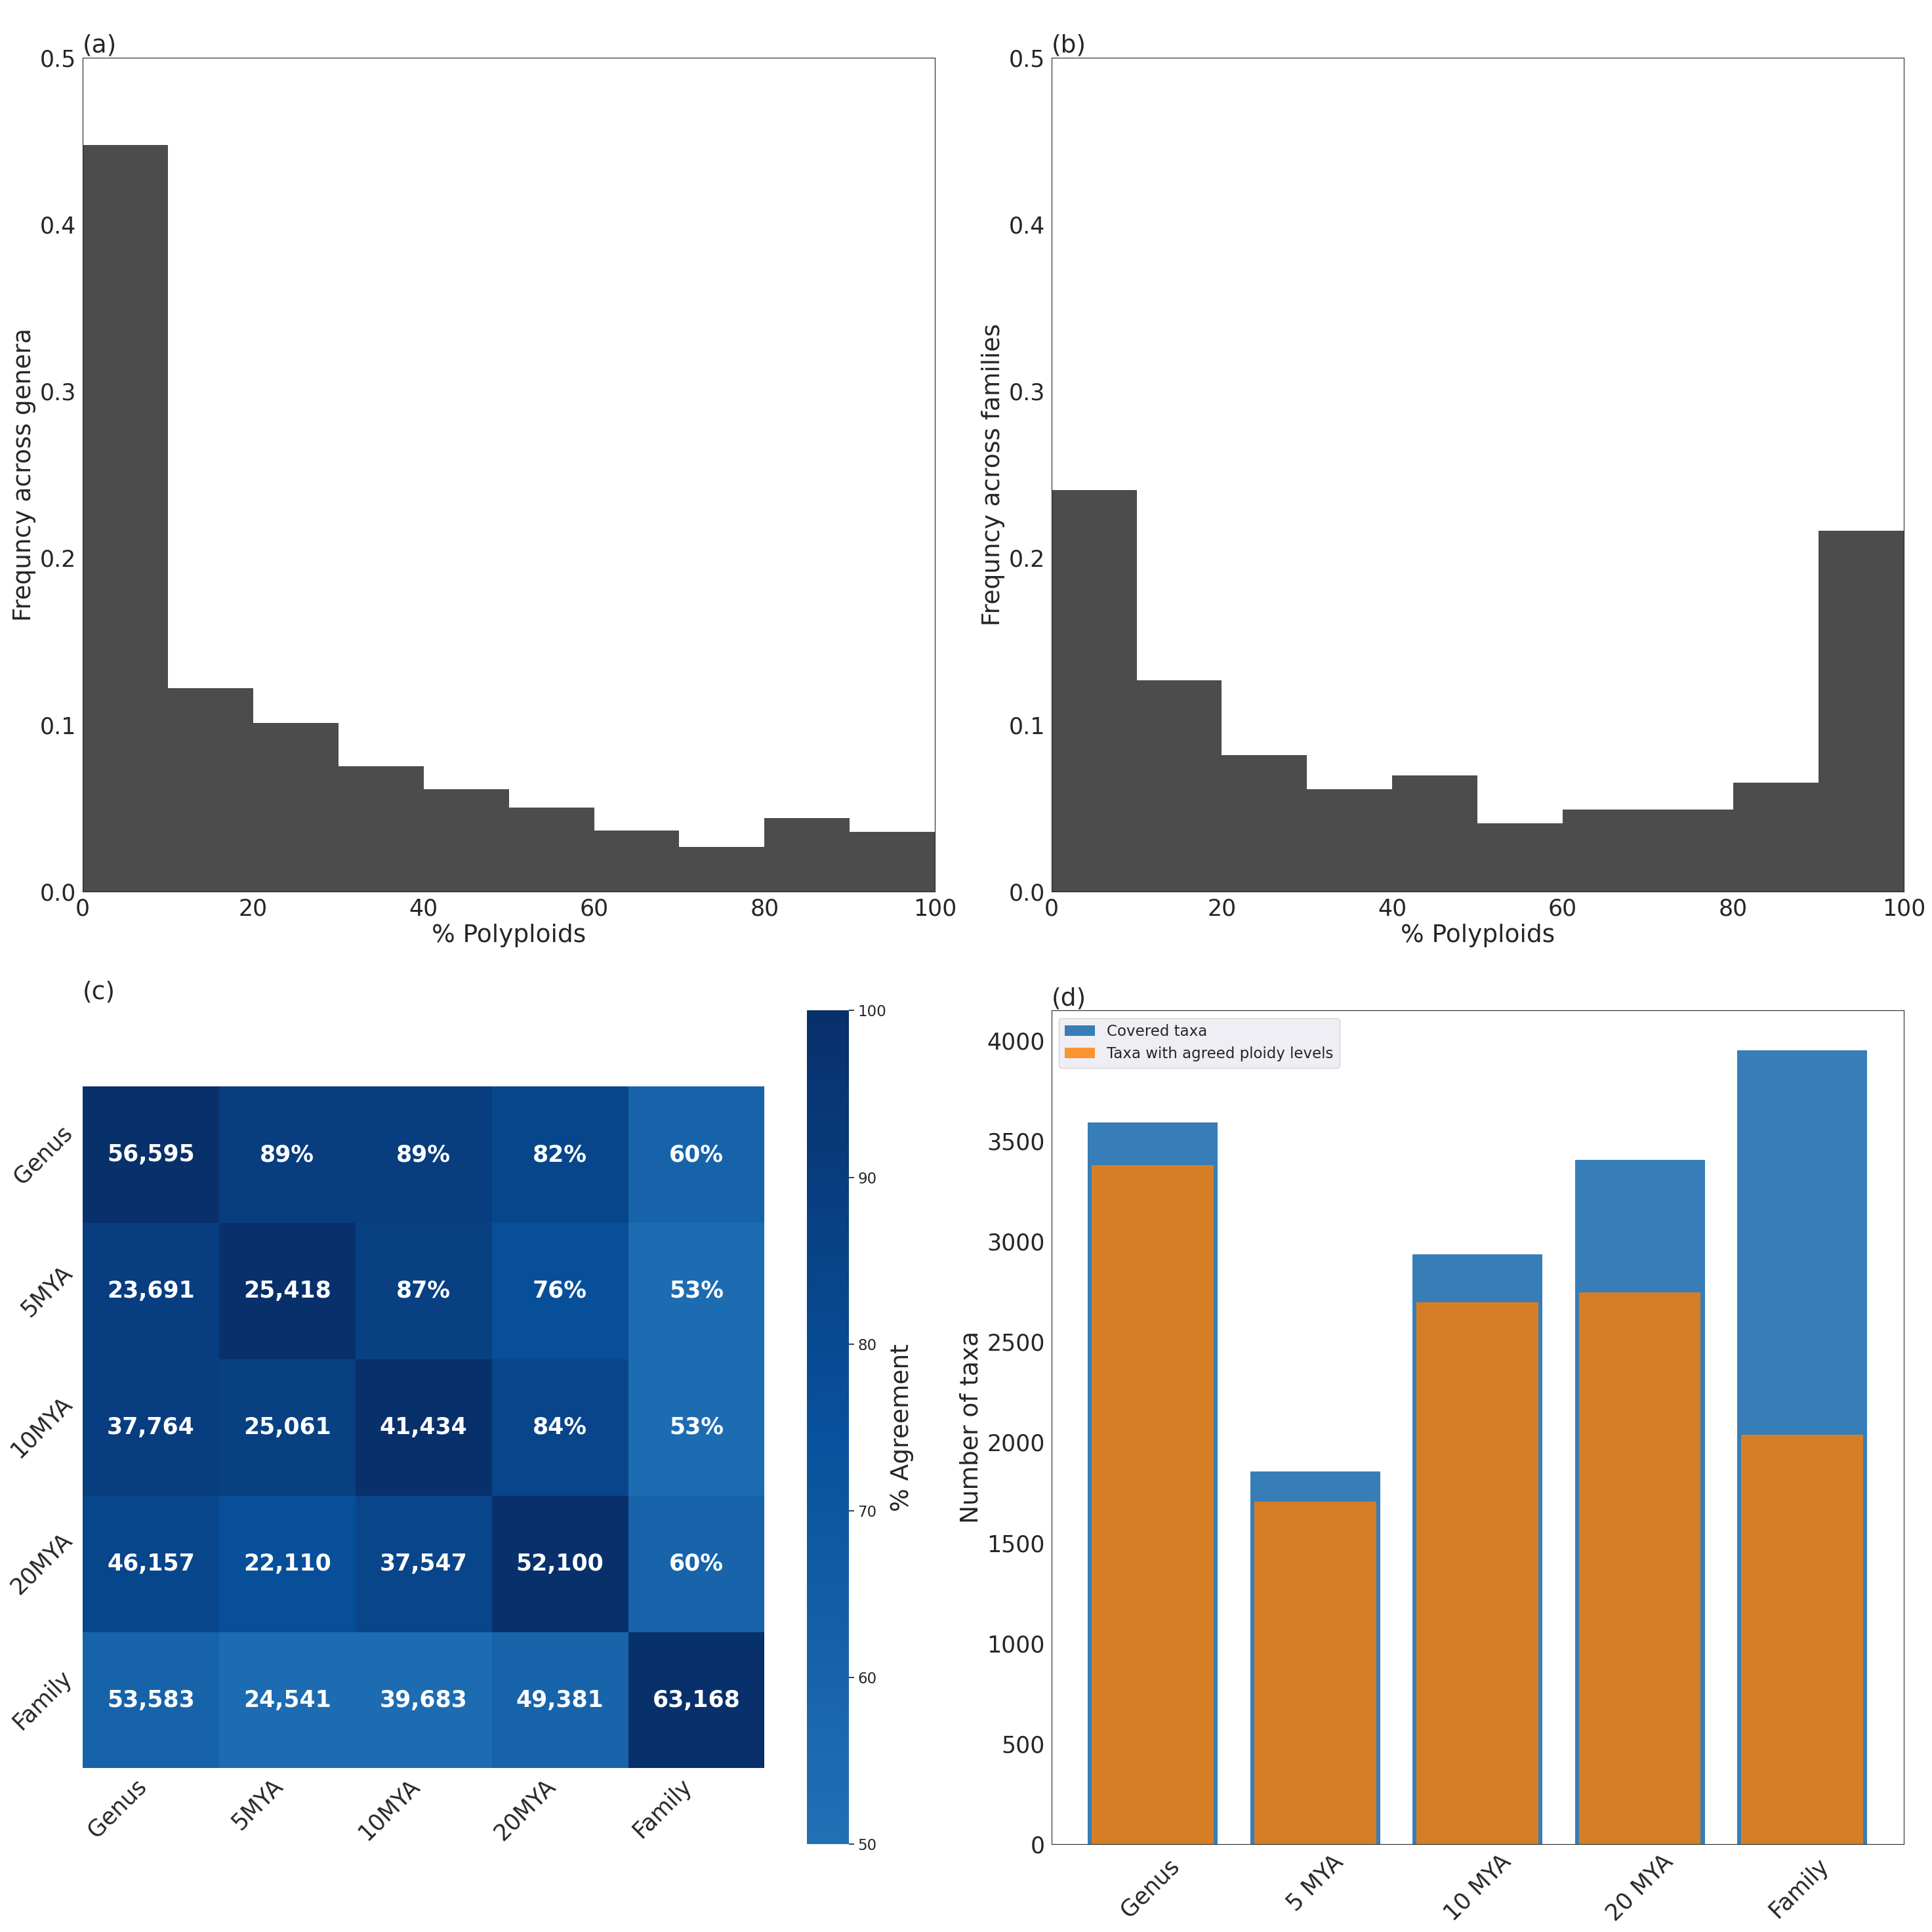

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,30)) #, gridspec_kw={'width_ratios': [1.5, 1]})
fontsize=25


plt.rcParams.update({'font.size': fontsize, 'font.weight': 'normal', 'axes.grid': False, 'savefig.transparent': False})
sns.set_style("white")
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']
nbins = 10

genus_level_db = comb_to_db[False]["genus"].loc[comb_to_db[False]["genus"]['Ploidy inference'].notna()]
family_level_db = comb_to_db[False]["family"].loc[comb_to_db[False]["family"]['Ploidy inference'].notna()]

genus_level_db_by_genus = genus_level_db.groupby("genus")["Ploidy inference"].apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
family_level_db_by_genus = family_level_db.groupby("Genus")["Ploidy inference"].apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
print(f"# covered genera at genus level = {genus_level_db_by_genus.shape[0]:,}")
print(f"# covered geneta  at family level = {family_level_db_by_genus.shape[0]:,}")

genus_level_db_by_family = genus_level_db.groupby("Family")["Ploidy inference"].apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
family_level_db_by_family = family_level_db.groupby("family")["Ploidy inference"].apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
print(f"# covered families at genus level = {genus_level_db_by_family.shape[0]:,}")
print(f"# covered families  at family level = {family_level_db_by_family.shape[0]:,}")

ax = axes[0][0]
ax.set_title("(a)", fontsize=fontsize+2, loc='left')
sns.histplot(x=genus_level_db_by_genus,ax=ax, color="black", label="genus-level inference", bins=nbins, alpha = 0.7, linewidth=0, stat="probability")
ax.set_ylabel("Frequncy across genera", fontsize=fontsize+2)
ax.set_xlabel("% Polyploids", fontsize=fontsize+2)
ax.set_ylim((0,0.5))
ax.set_xlim((0,100))
ax.patch.set_facecolor('white')
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax = axes[0][1]
ax.set_title("\n(b)", fontsize=fontsize+2, loc='left')
sns.histplot(x=family_level_db_by_family,ax=ax, color="black", label="family-level inference", bins=nbins, alpha = 0.7, linewidth=0, stat="probability")
ax.set_ylabel("Frequncy across families", fontsize=fontsize+2)
ax.set_xlabel("% Polyploids", fontsize=fontsize+2)
ax.set_ylim((0,0.5))
ax.set_xlim((0,100))
ax.patch.set_facecolor('white')
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax = axes[1][0]
sns.set(font_scale=1.5)
# matrix = np.triu(agreements)
sns.heatmap(
    agreements, 
    # mask=matrix,
    vmin=50, vmax=100, center=0, 
    annot=labels,
    fmt = '',
    square=True,
    ax=ax,
    cmap="Blues",
    annot_kws={"fontsize": fontsize,
              "fontweight": "bold"},
    cbar_kws={'label': '% Agreement'}
)
ax.figure.axes[-1].yaxis.label.set_size(fontsize+2)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    fontsize=fontsize,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    # rotation=45,
    horizontalalignment='right',
    fontsize=fontsize,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)
ax.set_title("(c)\n\n\n", loc="left", fontsize=fontsize+2)


ax = axes[1][1]
df_to_plot["% agreement"] = df_to_plot["# taxa in ploidy level agreement"]/df_to_plot["# taxa with chromosome number agreement"]*100
df_to_plot = pd.concat([df_to_plot.iloc[:1], df_to_plot.iloc[2:], df_to_plot.iloc[1:2]])

df_to_plot.set_index("scheme", inplace=True)
df_to_plot = df_to_plot.loc[["Genus ", "5 MYA", "10 MYA", "20 MYA", "Family "]]
df_to_plot.reset_index(inplace=True)

df_to_plot.plot(x="scheme", y="# taxa with chromosome number agreement", kind="bar", ax=ax, label="Covered taxa", width=0.8, linewidth=0, alpha=1, color=colors[0]) #"#7b3294")
df_to_plot.plot(x="scheme", y="# taxa in ploidy level agreement", kind="bar", ax=ax, label="Taxa with agreed ploidy levels", width=0.75, linewidth=0, alpha=0.8, color=colors[1]) #"#008837")
# ax.legend(fontsize=fontsize, loc="right")
ax.set_xlabel("")
ax.set_ylabel("Number of taxa",fontsize=fontsize+2)
ax.set_title("(d)", loc="left", fontsize=fontsize+2)
ax.patch.set_facecolor('white')
ax.grid(False)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
ax.set_xticklabels(df_to_plot.scheme.tolist(), rotation=45, fontsize=fontsize)

plt.tight_layout(pad=1.5)
fig.savefig("./Fig3.jpeg")


In [50]:
df_to_plot

,scheme,# taxa with chromosome number agreement,# taxa in ploidy level agreement,% pl agreement,% agreement
0,Genus,3591,3380,94.124199,94.124199
1,5 MYA,1853,1705,92.012952,92.012952
2,10 MYA,2933,2696,91.919536,91.919536
3,20 MYA,3404,2744,80.611046,80.611046
4,Family,3950,2036,51.544304,51.544304


## debug - check for hard contradictions between genus-level inference with and without missing data - along with comparison to kew db

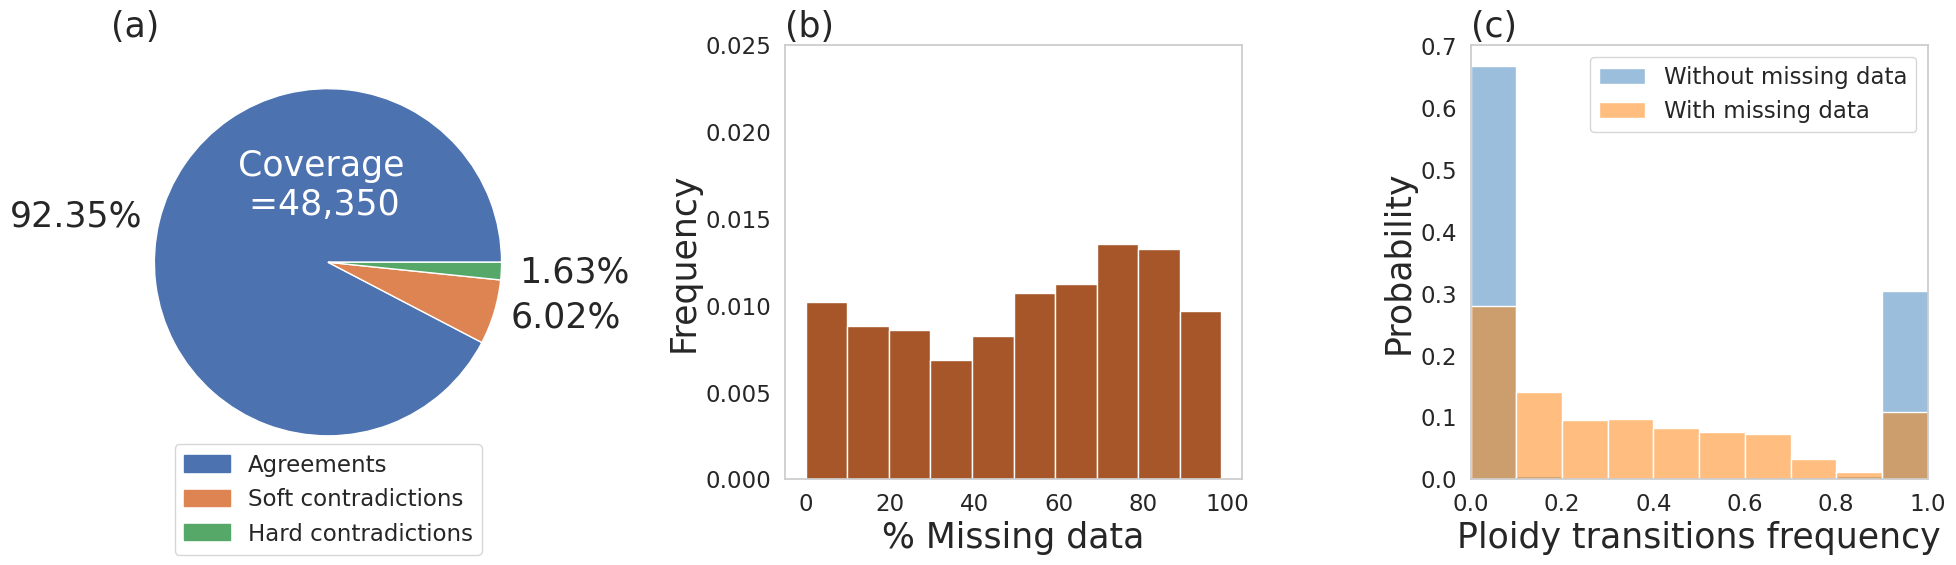

In [51]:
from matplotlib import patches
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})

group_by_options=["genus"]

fig, axes = plt.subplots(nrows=len(group_by_options), ncols=3, figsize=(20,6))
ax = axes[0]
db_wo_missing = comb_to_db[False][gb][["Taxon", "Chromosome count", "Ploidy inference", "genus"]].rename(columns={"Ploidy inference": "Ploidy inference_wo_missing"})
db_w_missing = comb_to_db[True][gb][["Taxon", "Chromosome count", "Ploidy inference", "genus"]].rename(columns={"Ploidy inference": "Ploidy inference_w_missing"})
intersection_taxa = set(db_wo_missing.Taxon) & set(db_w_missing.Taxon) 
coverage = len(intersection_taxa)
joined_db = db_wo_missing.merge(db_w_missing, on="Taxon", how="inner").drop_duplicates()
assert (joined_db.shape[0] == coverage)
num_agreements = joined_db.loc[joined_db["Ploidy inference_wo_missing"] == joined_db["Ploidy inference_w_missing"]].shape[0]
num_soft_contradictions = joined_db.loc[(joined_db["Ploidy inference_wo_missing"] != joined_db["Ploidy inference_w_missing"]) &
                                       (joined_db["Ploidy inference_wo_missing"].isna() | joined_db["Ploidy inference_w_missing"].isna())].shape[0]
num_hard_contradictions = joined_db.loc[(joined_db["Ploidy inference_wo_missing"] != joined_db["Ploidy inference_w_missing"]) &
                                   (joined_db["Ploidy inference_wo_missing"].notna()) & (joined_db["Ploidy inference_w_missing"].notna())].shape[0]
dist = np.array([num_agreements/coverage*100, num_soft_contradictions/coverage*100, num_hard_contradictions/coverage*100])
pie = ax.pie(dist, labels=[f"{np.round(d,2)}%" for d in dist], textprops={'fontsize': fontsize}) #, textprops=dict(color="w"), autopct=lambda pct: f"{np.round(pct,2)}%")
ax.text(-0.52, 0.27, f'Coverage \n ={coverage:,}', fontdict={"color": "white", "fontsize": fontsize})
ax.set_title("(a)", fontsize=fontsize, loc='left')
labels = ["Agreements", "Soft contradictions", "Hard contradictions"]
patches = [patches.Patch(color=pie[0][i]._facecolor, label=labels[i]) for i in range(len(labels))]
ax.legend(handles=patches, loc='lower left', bbox_to_anchor=(0.12, -0.2))

ax = axes[1]
ax.set_ylabel("Frequency", fontsize=fontsize)
ax.set_xlabel("% Missing data", fontsize=fontsize)
ax.set_ylim(0, 0.025)
ax.set_title("(b)", fontsize=fontsize, loc='left')
db_w_missing.groupby("genus")["Chromosome count"].apply(lambda x: (x == 'x').sum() / x.shape[0]*100).hist(ax=ax, grid=False,density=True, color=colors[4])

ax = axes[2]
db_wo_missing = comb_to_db[False]["genus"]
db_w_missing = comb_to_db[True]["genus"]
sns.histplot(db_wo_missing["Ploidy transitions frequency"], color=colors[0], ax=ax, alpha=0.5, label="Without missing data", stat="probability", bins=10)
sns.histplot(db_w_missing["Ploidy transitions frequency"], color=colors[1], ax=ax, alpha=0.5, label="With missing data", stat="probability", bins=10)
ax.set_xlabel("Ploidy transitions frequency", fontsize=fontsize)
ax.set_ylabel("Probability", fontsize=fontsize)
ax.legend()
ax.set_xlim(0,1)
ax.set_title("(c)", fontsize=fontsize, loc='left')
    
fig.tight_layout()
fig.savefig("FigS3_only_genus.jpeg", bbox_inches="tight")

In [52]:
soft_contradictions = joined_db.loc[(joined_db["Ploidy inference_wo_missing"] != joined_db["Ploidy inference_w_missing"]) &
                                       (joined_db["Ploidy inference_wo_missing"].isna() | joined_db["Ploidy inference_w_missing"].isna())]
hard_contradictions = joined_db.loc[(joined_db["Ploidy inference_wo_missing"] != joined_db["Ploidy inference_w_missing"]) &
                                   (joined_db["Ploidy inference_wo_missing"].notna()) & (joined_db["Ploidy inference_w_missing"].notna())]

In [53]:
soft_contradictions_genera = set(soft_contradictions.genus_x.unique())
hard_contradictions_genera = set(hard_contradictions.genus_x.unique())

soft_debug = pd.DataFrame({"genus": list(soft_contradictions_genera),
                                 "contradiction_type": "soft"})
soft_debug["frac_contradictions"] = soft_debug.genus.apply(lambda genus: soft_contradictions.loc[soft_contradictions.genus_x == genus].shape[0] / joined_db.loc[joined_db.genus_x == genus].shape[0])
                         
hard_debug =  pd.DataFrame({"genus": list(hard_contradictions_genera),
                                 "contradiction_type": "hard"})
hard_debug["frac_contradictions"] = hard_debug.genus.apply(lambda genus: hard_contradictions.loc[hard_contradictions.genus_x == genus].shape[0] / joined_db.loc[joined_db.genus_x == genus].shape[0])
 

debug = pd.concat([hard_debug, soft_debug])
debug.head()           

,genus,contradiction_type,frac_contradictions
0,sanicula,hard,0.923077
1,garcinia,hard,0.454545
2,lasthenia,hard,0.150000
3,lupinus,hard,0.958678
4,viola,hard,0.003390


In [54]:
models = ['gain_loss', 'gain_loss_dupl', 'gain_loss_dupl_demiPloidyR', 'gain_loss_baseNum_baseNumR', 'gain_loss_dupl_baseNum_baseNumR', 'gain_loss_dupl_baseNum_baseNumR_demiPloidyR']

def get_aicc_scores(genus: str, include_missing: bool) -> list:
    try:
        log_path = f"../chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb{'' if not include_missing else '_include_all_possible_missing'}/{genus}/pipeline.log"
        model_score_regex = re.compile("model=(.*?) has score of (-?\d*\.?\d*)")
        model_to_score = {}
        with open(log_path, "r") as f:
            log = f.read()
        for match in model_score_regex.finditer(log):
            model_to_score[match.group(1)] = float(match.group(2))
        return [model_to_score[model] for model in models]
    except Exception as e:
        print(genus, e)
        return [np.nan]*len(models)
    
debug[[f"wo_missing_{model}_aicc" for model in models]] = debug.parallel_apply(lambda rec: get_aicc_scores(rec.genus, include_missing=False), result_type="expand", axis=1)
debug[[f"w_missing_{model}_aicc" for model in models]] = debug.parallel_apply(lambda rec: get_aicc_scores(rec.genus, include_missing=True), result_type="expand", axis=1)                                                          

sedum 'gain_loss_dupl_baseNum_baseNumR_demiPloidyR'


In [55]:
for model in models:
    debug[f"{model}_aicc_diff"] = debug[f"wo_missing_{model}_aicc"]-debug[f"w_missing_{model}_aicc"]

In [56]:
cols_order = ["genus", "contradiction_type", "frac_contradictions"]
for model in models:
    cols_order += [f"wo_missing_{model}_aicc", f"w_missing_{model}_aicc", f"{model}_aicc_diff"]
debug = debug[cols_order]

In [57]:
debug

,genus,contradiction_type,frac_contradictions,wo_missing_gain_loss_aicc,w_missing_gain_loss_aicc,gain_loss_aicc_diff,wo_missing_gain_loss_dupl_aicc,w_missing_gain_loss_dupl_aicc,gain_loss_dupl_aicc_diff,wo_missing_gain_loss_dupl_demiPloidyR_aicc,...,gain_loss_dupl_demiPloidyR_aicc_diff,wo_missing_gain_loss_baseNum_baseNumR_aicc,w_missing_gain_loss_baseNum_baseNumR_aicc,gain_loss_baseNum_baseNumR_aicc_diff,wo_missing_gain_loss_dupl_baseNum_baseNumR_aicc,w_missing_gain_loss_dupl_baseNum_baseNumR_aicc,gain_loss_dupl_baseNum_baseNumR_aicc_diff,wo_missing_gain_loss_dupl_baseNum_baseNumR_demiPloidyR_aicc,w_missing_gain_loss_dupl_baseNum_baseNumR_demiPloidyR_aicc,gain_loss_dupl_baseNum_baseNumR_demiPloidyR_aicc_diff
0,sanicula,hard,0.923077,92.7146,90.5166,2.1980,62.1023,60.7942,1.3081,52.4300,...,6.0466,43.1514,57.2956,-14.1442,45.1522,44.2827,0.8695,47.1594,46.2782,0.8812
1,garcinia,hard,0.454545,84.3254,178.8470,-94.5216,80.0640,123.5040,-43.4400,82.0780,...,-10.1396,81.3756,89.0234,-7.6478,83.4085,91.0189,-7.6104,85.1990,92.0119,-6.8129
2,lasthenia,hard,0.150000,110.0090,107.5270,2.4820,98.8026,98.8416,-0.0390,87.0299,...,0.0055,84.2864,105.1290,-20.8426,83.7971,102.7520,-18.9549,84.2162,91.0285,-6.8123
3,lupinus,hard,0.958678,748.0730,1282.2700,-534.1970,719.6910,721.6760,-1.9850,615.2440,...,-0.1200,614.6130,688.9080,-74.2950,608.6980,701.2180,-92.5200,619.2620,619.2900,-0.0280
4,viola,hard,0.003390,2520.8100,7000.7000,-4479.8900,1775.8500,1759.3500,16.5000,1731.8700,...,2.8300,1977.6300,1946.9900,30.6400,1742.9700,1794.9600,-51.9900,1721.9300,1721.7200,0.2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,olearia,soft,0.016393,1191.0500,990.2410,200.8090,483.4670,474.5820,8.8850,326.4870,...,4.6000,323.8430,673.1430,-349.3000,316.6140,478.5810,-161.9670,298.3750,325.8750,-27.5000
165,vitex,soft,0.066667,87.3041,109.4630,-22.1589,70.4381,70.5310,-0.0929,72.5003,...,0.0133,72.1890,72.2655,-0.0765,74.3175,72.8291,1.4884,74.8039,74.8285,-0.0246
166,brodiaea,soft,0.058824,98.8197,99.4837,-0.6640,80.2764,80.2708,0.0056,81.9222,...,-0.0048,95.8174,95.8413,-0.0239,76.0114,76.0107,0.0007,77.2589,78.0853,-0.8264
167,scandix,soft,0.200000,57.4952,59.0959,-1.6007,61.0988,61.0970,0.0018,61.2214,...,0.1336,60.2426,63.0964,-2.8538,63.3544,65.0972,-1.7428,64.7700,65.1743,-0.4043


In [58]:
db_w_missing.loc[(db_w_missing.genus == 'heliomeris') & (db_w_missing['Ploidy inference'].isna())][[c for c in db_w_missing if "Unnamed" not in c]].sort_values("Taxon")

,Family,Genus,Taxon,Ploidy inference,Chromosome count,Ploidy transitions frequency,Ploidy classification reliability,frequency_of_successful_mappings,Phylogenetically reliable,genus,polyploidy_threshold,diploidy_threshold,polyploidy_coeff,diploidy_coeff,selected_model,flag,max_delta_aicc,Phylogenetically unreliable,major_group
137614,asteraceae,heliomeris,heliomeris annua,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137611,asteraceae,heliomeris,heliomeris hispida,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137612,asteraceae,heliomeris,heliomeris hispidus,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137607,asteraceae,heliomeris,heliomeris longifolia,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137608,asteraceae,heliomeris,heliomeris multiflora,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137613,asteraceae,heliomeris,heliomeris multiflora var. brevifolia,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137610,asteraceae,heliomeris,heliomeris multiflora var. nevadensis,NaN,8.0,0.354342,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms
137609,asteraceae,heliomeris,heliomeris soliceps,NaN,x,0.283793,NaN,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,4.631,NaN,angiosperms


In [59]:
db_wo_missing.loc[(db_wo_missing.genus == 'heliomeris') & (db_wo_missing['Ploidy inference'].notna())][[c for c in db_w_missing if "Unnamed" not in c]].sort_values("Taxon")

,Family,Genus,Taxon,Ploidy inference,Chromosome count,Ploidy transitions frequency,Ploidy classification reliability,frequency_of_successful_mappings,Phylogenetically reliable,genus,polyploidy_threshold,diploidy_threshold,polyploidy_coeff,diploidy_coeff,selected_model,flag,max_delta_aicc,Phylogenetically unreliable,major_group
43,asteraceae,heliomeris,heliomeris annua,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
40,asteraceae,heliomeris,heliomeris hispida,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
39,asteraceae,heliomeris,heliomeris hispidus,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
37,asteraceae,heliomeris,heliomeris longifolia,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
44,asteraceae,heliomeris,heliomeris longifolia var. annua,0.0,4,0.00000,1.000000,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
38,asteraceae,heliomeris,heliomeris multiflora,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
42,asteraceae,heliomeris,heliomeris multiflora var. brevifolia,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
41,asteraceae,heliomeris,heliomeris multiflora var. nevadensis,1.0,8,0.85161,0.406438,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms
36,asteraceae,heliomeris,heliomeris obscura,1.0,13,1.00000,1.000000,1.0,NaN,heliomeris,0.75,NaN,NaN,NaN,NaN,standard,9.3698,False,angiosperms


In [60]:
states_comparison = classification[['taxon',
                                    'kew_db_chromosome_number', 
                                    'kew_db_ploidy_inference',
                                    'by_genus_without_missing_flag',
                                    'by_genus_without_missing_ploidy_inference',
                                    'by_genus_without_missing_chromosome_count',
                                    'by_genus_without_missing_ploidy_transitions_frequency',
                                    'by_genus_without_missing_frequency_of_successful_mappings',
                                    'by_genus_with_missing_flag',
                                    'by_genus_with_missing_ploidy_inference',
                                    'by_genus_with_missing_chromosome_count',
                                    'by_genus_with_missing_ploidy_transitions_frequency',
                                    'by_genus_with_missing_frequency_of_successful_mappings']].dropna(subset=["by_genus_without_missing_flag", "by_genus_with_missing_flag"], how="any")
print(f"at genus level inference:\n# intersection taxa = {states_comparison.shape[0]:,}")
contradicted_states_comparison = states_comparison.loc[states_comparison.by_genus_without_missing_ploidy_inference != states_comparison.by_genus_with_missing_ploidy_inference]
soft_contradictions = contradicted_states_comparison.loc[(contradicted_states_comparison.by_genus_without_missing_ploidy_inference.isna()) | (contradicted_states_comparison.by_genus_with_missing_ploidy_inference.isna())]
hard_contradictions = contradicted_states_comparison.loc[(contradicted_states_comparison.by_genus_without_missing_ploidy_inference.notna()) & (contradicted_states_comparison.by_genus_with_missing_ploidy_inference.notna())]
print(f"# contradictions = {contradicted_states_comparison.shape[0]:,}\n# soft contradictions = {soft_contradictions.shape[0]:,}\n# hard contradictions = {hard_contradictions.shape[0]:,}")
print(f"\n% contradictions = {np.round(contradicted_states_comparison.shape[0]/states_comparison.shape[0]*100,2):,}%\n% soft contradictions = {np.round(soft_contradictions.shape[0]/contradicted_states_comparison.shape[0]*100,2):,}%\n% hard contradictions = {np.round(hard_contradictions.shape[0]/contradicted_states_comparison.shape[0]*100,2):,}%")


hard_contradictions_in_kew = contradicted_states_comparison.loc[contradicted_states_comparison.kew_db_ploidy_inference.notna()]
print(f"\nout of hard contradictions:\n# hard contradictroy taxa with available ploidy level in kew db = {hard_contradictions_in_kew.shape[0]:,}")                              
hard_contradictions_state_1_same_as_kew = hard_contradictions_in_kew.loc[hard_contradictions_in_kew.by_genus_without_missing_ploidy_inference == hard_contradictions_in_kew.kew_db_ploidy_inference]
hard_contradictions_state_2_same_as_kew = hard_contradictions_in_kew.loc[hard_contradictions_in_kew.by_genus_with_missing_ploidy_inference == hard_contradictions_in_kew.kew_db_ploidy_inference]
print(f"# taxa with same ploidy level in state 1 and in kew db = {hard_contradictions_state_1_same_as_kew.shape[0]:,}\n# taxa with same ploidy level in state 2 and in kew db = {hard_contradictions_state_2_same_as_kew.shape[0]:,}")                                                          
print(f"\n% taxa with same ploidy level in state 1 and in kew db = {np.round(hard_contradictions_state_1_same_as_kew.shape[0]/hard_contradictions_in_kew.shape[0]*100,2):,}%\n% taxa with same ploidy level in state 2 and in kew db = {np.round(hard_contradictions_state_2_same_as_kew.shape[0]/hard_contradictions_in_kew.shape[0]*100,2):,}%")                                                          


soft_contradictions_missing_in_state_1 = soft_contradictions.loc[soft_contradictions.by_genus_without_missing_ploidy_inference.isna()]
soft_contradictions_missing_in_state_2 = soft_contradictions.loc[soft_contradictions.by_genus_with_missing_ploidy_inference.isna()]
print(f"\nout of soft contradictions:\n# taxa with no ploidy inference in state 1 = {soft_contradictions_missing_in_state_1.shape[0]:,}\n# taxa with no ploidy inference in state 2 = {soft_contradictions_missing_in_state_2.shape[0]:,}")
print(f"\n%taxa with no ploidy inference in state 1 = {np.round(soft_contradictions_missing_in_state_1.shape[0]/soft_contradictions.shape[0]*100,2):,}%\n% taxa with no ploidy inference in state 2 = {np.round(soft_contradictions_missing_in_state_2.shape[0]/soft_contradictions.shape[0]*100,2):,}%")

at genus level inference:
# intersection taxa = 48,350
# contradictions = 3,700
# soft contradictions = 2,913
# hard contradictions = 787

% contradictions = 7.65%
% soft contradictions = 78.73%
% hard contradictions = 21.27%

out of hard contradictions:
# hard contradictroy taxa with available ploidy level in kew db = 176
# taxa with same ploidy level in state 1 and in kew db = 103
# taxa with same ploidy level in state 2 and in kew db = 30

% taxa with same ploidy level in state 1 and in kew db = 58.52%
% taxa with same ploidy level in state 2 and in kew db = 17.05%

out of soft contradictions:
# taxa with no ploidy inference in state 1 = 829
# taxa with no ploidy inference in state 2 = 2,484

%taxa with no ploidy inference in state 1 = 28.46%
% taxa with no ploidy inference in state 2 = 85.27%


In [61]:
relevant_classifications = classification.loc[classification.kew_db_ploidy_inference.notna() & classification.by_genus_without_missing_ploidy_inference.notna()]
relevant_contradictions = relevant_classifications.loc[relevant_classifications.kew_db_ploidy_inference != relevant_classifications.by_genus_without_missing_ploidy_inference]
relevant_contradictions = relevant_contradictions[["taxon", "genus", "kew_db_chromosome_number", "by_genus_without_missing_chromosome_count", "kew_db_ploidy_inference", "by_genus_without_missing_ploidy_inference"]].sort_values("genus")
print(f"# taxa with contadictory ploidy inference = {relevant_contradictions.shape[0]:,}")
relevant_contradictions_only_ploidy = relevant_contradictions.loc[relevant_contradictions.kew_db_chromosome_number == relevant_contradictions.by_genus_without_missing_chromosome_count]
print(f"# taxa with contadictory ploidy inference despite of identical chromosome count reports = {relevant_contradictions_only_ploidy.shape[0]:,}")
print(f"# genera for which such contradictory inferences were obtained = {len(relevant_contradictions_only_ploidy.genus.unique()):,}")
relevant_contradictions_only_ploidy.sort_values("taxon").iloc[:50]

# taxa with contadictory ploidy inference = 390
# taxa with contadictory ploidy inference despite of identical chromosome count reports = 211
# genera for which such contradictory inferences were obtained = 81


,taxon,genus,kew_db_chromosome_number,by_genus_without_missing_chromosome_count,kew_db_ploidy_inference,by_genus_without_missing_ploidy_inference
67815,adenocarpus foliolosus,adenocarpus,26.0,26.0,1.0,0.0
68334,aeonium canariense,aeonium,18.0,18.0,1.0,0.0
67793,aeonium ciliatum,aeonium,18.0,18.0,1.0,0.0
68284,aeonium goochiae,aeonium,18.0,18.0,1.0,0.0
68416,aeonium lindleyi,aeonium,18.0,18.0,1.0,0.0
68405,aeonium sedifolium,aeonium,18.0,18.0,1.0,0.0
67608,aeonium smithii,aeonium,18.0,18.0,1.0,0.0
68370,aeonium spathulatum,aeonium,18.0,18.0,1.0,0.0
68324,aeonium urbicum,aeonium,18.0,18.0,1.0,0.0
1361,agave schottii,agave,30.0,30.0,1.0,0.0


In [62]:
hard_contradictions_state_1_same_as_kew["genus"] = hard_contradictions_state_1_same_as_kew.taxon.apply(lambda l: l.split(" ")[0])
hard_contradictions_state_1_same_as_kew_by_genus = hard_contradictions_state_1_same_as_kew.groupby("genus")["taxon"].count().reset_index() #.sort_values("taxon")
hard_contradictions_state_1_same_as_kew_by_genus.sort_values("taxon", ascending=False)

,genus,taxon
8,hieracium,42
13,rubus,21
10,lupinus,9
0,astragalus,7
2,cerastium,5
1,brachypodium,3
5,convolvulus,3
9,iris,3
7,eryngium,2
15,sedum,2


In [63]:
# sns.set_style("whitegrid", {'axes.grid' : False})

# fig, axes = plt.subplots(nrows=1,
#                          ncols=len(group_by_options),
#                          figsize=(len(group_by_options)*6, 5),
#                         sharex=True,
#                         sharey=True)
# add_missing_options = [False, True]
# for gb in group_by_options:
#     ax_0 = axes[group_by_options.index(gb)]
#     db_wo_missing = comb_to_db[False][gb]
#     db_w_missing = comb_to_db[True][gb]
#     sns.histplot(db_wo_missing["Ploidy transitions frequency"], ax=ax_0, color=colors[0], alpha=0.5, label="without missing data", stat="probability", bins=10)
#     sns.histplot(db_w_missing["Ploidy transitions frequency"], ax=ax_0, color=colors[1], alpha=0.5, label="with missing data", stat="probability", bins=10)
    
#     if group_by_options.index(gb) == 2:
#         ax_0.set_xlabel("Ploidy transitions frequency")
        
#     if group_by_options.index(gb) == 4:
#         ax_0.legend()
    
#     ax_0.set_xlim(0,1)
    
#     level = gb.replace("time_", "").capitalize() + (" MYA" if "time" in gb else "")
#     ax_0.set_title(level)

Text(0.5, 1.0, 'Genus')

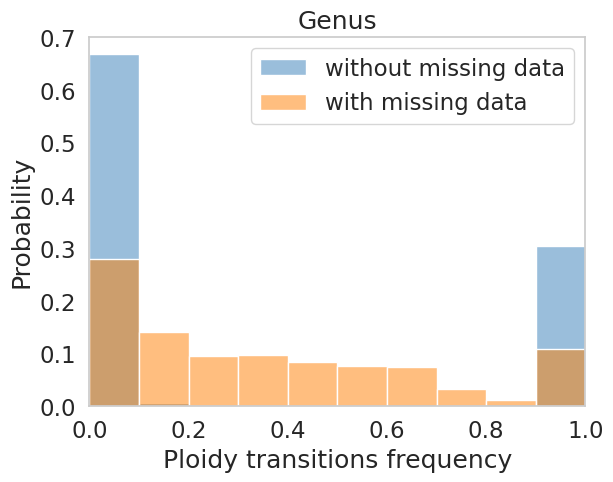

In [64]:
sns.set_style("whitegrid", {'axes.grid' : False})

add_missing_options = [False, True]
db_wo_missing = comb_to_db[False]["genus"]
db_w_missing = comb_to_db[True]["genus"]
sns.histplot(db_wo_missing["Ploidy transitions frequency"], color=colors[0], alpha=0.5, label="without missing data", stat="probability", bins=10)
sns.histplot(db_w_missing["Ploidy transitions frequency"], color=colors[1], alpha=0.5, label="with missing data", stat="probability", bins=10)
plt.xlabel("Ploidy transitions frequency")
plt.legend()
plt.xlim(0,1)
level = gb.replace("time_", "").capitalize() + (" MYA" if "time" in gb else "")
plt.title(level)